In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load, save
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
year='2018'
hists = load('../hists/darkhiggs'+year+'.scaled')

lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': "36.31",
        '2017': "41.53",
        '2018': "59.74"
    }
lumi=lumis[year]

fail_binning_dict={
    '2016': [0,0.53],
    '2017': [0,0.61],
    '2018': [0,0.65]
}
pass_binning_dict={
    '2016': [0.53,1],
    '2017': [0.61,1],
    '2018': [0.65,1]
}

fail_binning=fail_binning_dict[year]
pass_binning=pass_binning_dict[year]

data={
    '2016':{
        'sr': 'MET',
        'wmcr': 'MET',
        'tmcr': 'MET',
        'wecr': 'SingleElectron',
        #'wecr': 'EGamma',
        'tecr': 'SingleElectron',
        #'tecr': 'EGamma',
        'zmcr': 'MET',
        'zecr': 'SingleElectron',
        #'zecr': 'EGamma',
        'gcr': 'SinglePhoton',
        'qcdcr': 'MET'
        #'gcr': 'EGamma'
    },
    '2017':{
        'sr': 'MET',
        'wmcr': 'MET',
        'tmcr': 'MET',
        'wecr': 'SingleElectron',
        #'wecr': 'EGamma',
        'tecr': 'SingleElectron',
        #'tecr': 'EGamma',
        'zmcr': 'MET',
        'zecr': 'SingleElectron',
        #'zecr': 'EGamma',
        'gcr': 'SinglePhoton',
        'qcdcr': 'MET'
        #'gcr': 'EGamma'
    },
    '2018':{
        'sr': 'MET',
        'wmcr': 'MET',
        'tmcr': 'MET',
        'wecr': 'EGamma',
        'tecr': 'EGamma',
        'zmcr': 'MET',
        'zecr': 'EGamma',
        'gcr': 'EGamma',
        'qcdcr': 'MET'
    },
}

data_hists   = hists['data']
bkg_hists    = hists['bkg']
signal_hists = hists['sig']

mass_binning = [
    #0,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    120,
    150,
    180,
    240,
    300,
]
bkg_hists['template']=bkg_hists['template'].rebin('fjmass',hist.Bin('fjmass','Mass', mass_binning))
signal_hists['template']=signal_hists['template'].rebin('fjmass',hist.Bin('fjmass','Mass',mass_binning))
data_hists['template']=data_hists['template'].rebin('fjmass',hist.Bin('fjmass','Mass',mass_binning))

recoil_binning = [250, 310, 370, 470, 590, 3000]
bkg_hists['template']=bkg_hists['template'].rebin('recoil',hist.Bin('recoil','Recoil',recoil_binning))
signal_hists['template']=signal_hists['template'].rebin('recoil',hist.Bin('recoil','Recoil',recoil_binning))
data_hists['template']=data_hists['template'].rebin('recoil',hist.Bin('recoil','Recoil',recoil_binning))
    

In [9]:
exp = 0
exp_unc = 0
tot_bkg_yld_array={():0}

region = 'qcdcr'
category_map = {
    0 :'fail', 
    1 :'pass', 
    None : '',
}
category=None
sys='nominal'

bkg_hists_table=bkg_hists['template']
process = hist.Cat("process", "Process", sorting="placement")
cats = ("process",)
bkg_map = OrderedDict()
bkg_map[r'H$\rightarrow b\bar{b}$'] = ("Hbb*",)
bkg_map[r"Z($\rightarrow \ell\ell$)+jets"] = (["DY+HF","DY+LF"]),
bkg_map["QCD multijet"] = ("QCD*",)
bkg_map["Diboson"] = (["WW", "WZ", "ZZ"],)
bkg_map["Single t"] = (["ST"],)
bkg_map[r"$t\bar{t}$"] = (["TT"],)
bkg_map[r"W($\rightarrow \ell\nu$)+jets"] = (["W+HF","W+LF"],)
bkg_map[r"Z($\rightarrow \nu\nu$)+jets"] = (["Z+HF","Z+LF"],)
bkg_hists_table = bkg_hists_table.group(cats, process, bkg_map)
signal_hists_table=signal_hists['template']
data_hists_table=data_hists['template']
    
print('------------------------')
print('------------------------')
print('Category:', region, category_map[category])
#print('Recoil bins:',signal_hists['template'].axis('recoil').edges()[()].size-1,signal_hists['template'].axis('recoil').edges()[()])
#print('Mass bins:',signal_hists['template'].axis('fjmass').edges()[()].size-1,signal_hists['template'].axis('fjmass').edges()[()])
#print('Systematic:', sys)
#print('------------------------')
print('------------------------')
print('------------------------')
for p in bkg_hists_table.identifiers('process'):
    bkg_yld_array = bkg_hists_table.integrate('region',region).integrate('process', p).integrate('systematic',sys).values(sumw2=True)#(overflow='all')
    if () in bkg_yld_array:
        yld = bkg_yld_array[()][0][:,:,category].sum()
        unc = bkg_yld_array[()][1][:,:,category].sum()
        tot_bkg_yld_array[()]+=bkg_yld_array[()][0]
        exp += yld
        exp_unc += unc
        print(p, '%.1f' % yld, '$\pm$', '%.1f' % np.sqrt(unc))

print('------------------------')
print('Total expected:', '%.1f' % exp, '$\pm$', '%.1f' % np.sqrt(exp_unc))
print('------------------------')

if not (region == 'sr' and category==1):
    yld_array = data_hists_table.integrate('region',region).integrate('process', data[year][region]).integrate('systematic',sys).values()#(overflow='all')
    if () in yld_array:
        yld = yld_array[()][:,:,category].sum()
        print('Total observed:', '%.1f' % yld)   
print('------------------------')

if (region == 'sr' and category==1):
    for p in signal_hists_table.identifiers('process'):
        if 'Mz500' not in str(p): continue
        if 'Mdm150' not in str(p): continue
        sig_yld_array = signal_hists_table.integrate('region',region).integrate('process', p).integrate('systematic',sys).values()#(overflow='all')
        if () in sig_yld_array:
            yld = sig_yld_array[()][:,:,category].sum()
            print(p, '%.1f' % yld)
            #print(p,'S/B %.3f' % (yld/exp))
            print(p,'Significance %.1f' % (yld/np.sqrt(exp)))
            binned_significance=0
            for recoil in range(0,signal_hists_table.axis('recoil').edges()[()].size-2):
                for mass in range(0,signal_hists_table.axis('fjmass').edges()[()].size-2):
                    pice=np.nan_to_num(sig_yld_array[()][recoil,mass,category].sum()/np.sqrt(tot_bkg_yld_array[()][recoil,mass,category].sum()))
                    binned_significance=binned_significance+(pice*pice)
            print(p,'Binned Sig. %.2f' % np.sqrt(binned_significance))
            print('------------------------')


------------------------
------------------------
Category: qcdcr 
------------------------
------------------------
QCD multijet 7720.0 $\pm$ 279.6
Diboson 70.4 $\pm$ 7.3
Single t 39.0 $\pm$ 3.1
$t\bar{t}$ 365.1 $\pm$ 35.8
W($\rightarrow \ell\nu$)+jets 1293.6 $\pm$ 28.5
Z($\rightarrow \nu\nu$)+jets 1904.0 $\pm$ 15.3
------------------------
Total expected: 11392.1 $\pm$ 283.9
------------------------
Total observed: 14296.0
------------------------


In [3]:
###
# To optimize cuts based on process yield, i.e. you wanna test some background rejection
###

exp = 0
region = 'wmcr'
category_map = {
    0 :'fail', 
    1 :'pass', 
    None : '',
}
category=1
variable = 'fj1pt'
cut_bin = 0
nbins = data_hists[variable].integrate('region').integrate('process', 'MET').values(overflow='all')[()].size
cut_value_array = data_hists[variable].integrate('region').integrate('process', 'MET').axis(variable).edges(overflow='all')

print('------------------------')
print('------------------------')
print('Category:', region, category_map[category])
#print('------------------------')
if cut_bin!=None: print(variable,'> %.2f' % cut_value_array[()][cut_bin+1])
#if cut_bin!=None: print(variable,'< %.2f' % cut_value_array[()][cut_bin+1])
print('------------------------')
print('------------------------')
for p in bkg_hists[variable].identifiers('process'):
    yld_array = bkg_hists[variable].integrate('region',region).integrate('process', p).values()
    if () in yld_array:
        #yld = np.cumsum(yld_array[()])[nbins-1]
        yld = yld_array[()][:,category].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[()][:,category])[cut_bin]
        #if cut_bin!=None: yld = np.cumsum(yld_array[()])[cut_bin]
        exp += yld
        print(p, '%.1f' % yld)

print('------------------------')
print('Total expected:', '%.1f' % exp)
print('------------------------')

for p in signal_hists[variable].identifiers('process'):
    yld_array = signal_hists[variable].integrate('region',region).integrate('process', p).values()
    if () in yld_array:
        #yld = np.cumsum(yld_array[()])[nbins-1]
        yld = yld_array[()][:,category].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[()][:,category])[cut_bin]
        #yld = yld_array[()].sum()
        #if cut_bin!=None: yld = yld - np.cumsum(yld_array[()])[cut_bin]
        #if cut_bin!=None: yld = np.cumsum(yld_array[()])[cut_bin]
        print(p, '%.1f' % yld)
        print(p,'S/B %.3f' % (yld/exp))
        print(p,'S/sqrt(B) %.1f' % (yld/np.sqrt(exp)))
        #print(p,'Fraction %.2f' % (yld/np.cumsum(yld_array[()])[16]))
        print('------------------------')

if not region == '':
    yld_array = data_hists[variable].integrate('region',region).integrate('process', data[year][region]).values()
    if () in yld_array:
        #yld = np.cumsum(yld_array[()])[nbins-1]
        yld = yld_array[()][:,category].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[()][:,category])[cut_bin]
        #yld = yld_array[()].sum()
        #if cut_bin!=None: yld = yld - np.cumsum(yld_array[()])[cut_bin]
        #if cut_bin!=None: yld = np.cumsum(yld_array[()])[cut_bin]
        print('Total observed:', '%.1f' % yld)   
print('------------------------')
print()

------------------------
------------------------
Category: wmcr pass
fj1pt > 160.00
------------------------
------------------------
Hbb 77.1
DY+HF 85.3
DY+LF 100.9
WW 354.2
WZ 194.5
ZZ 5.4
ST 3749.3
TT 22389.6
W+HF 3038.4
W+LF 3442.6
QCD 816.5
------------------------
Total expected: 34253.8
------------------------
Total observed: 28410.0
------------------------



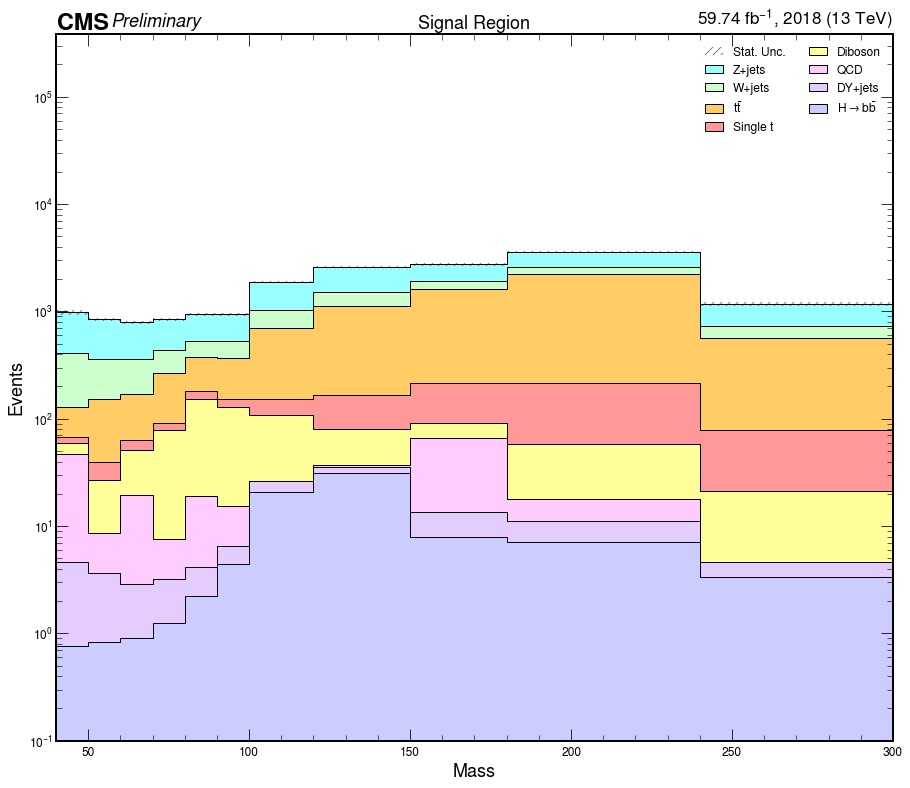

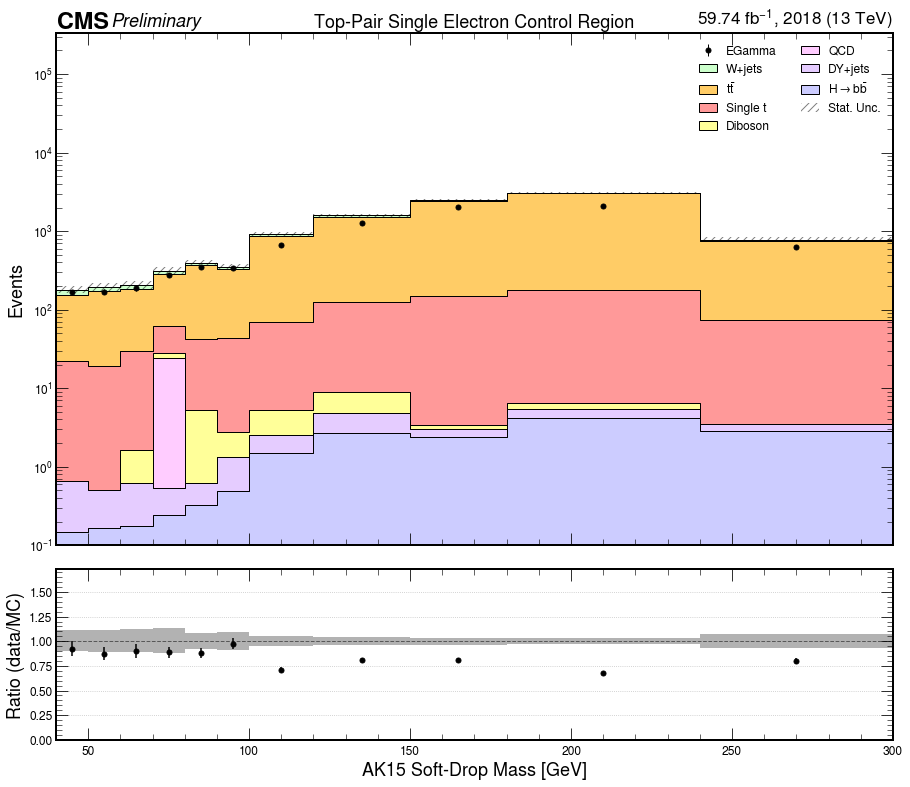

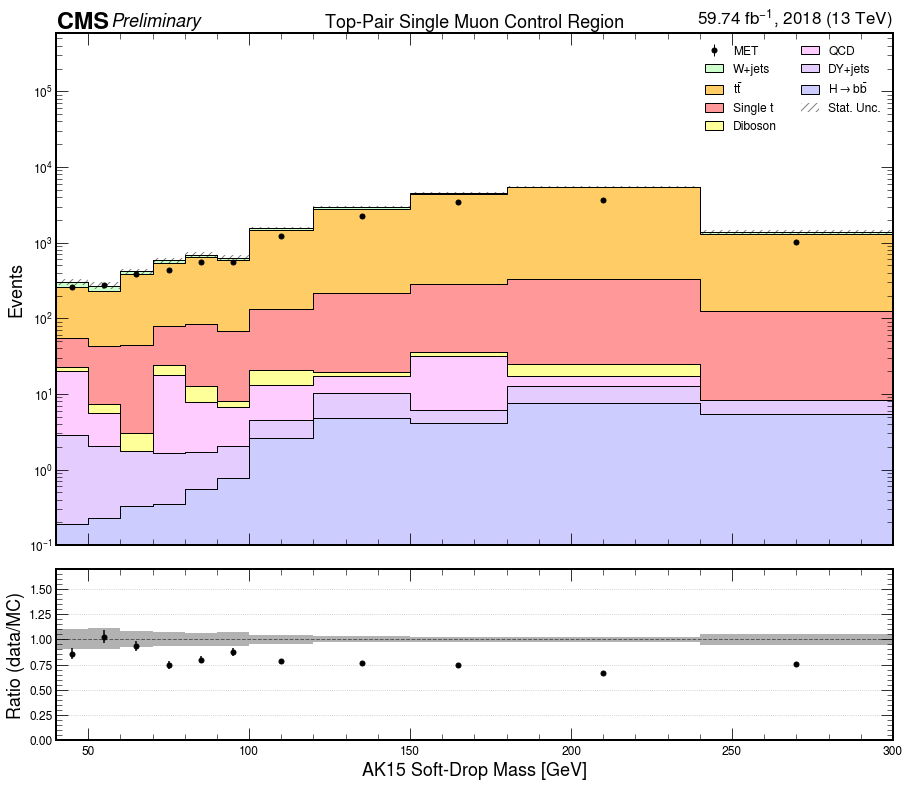

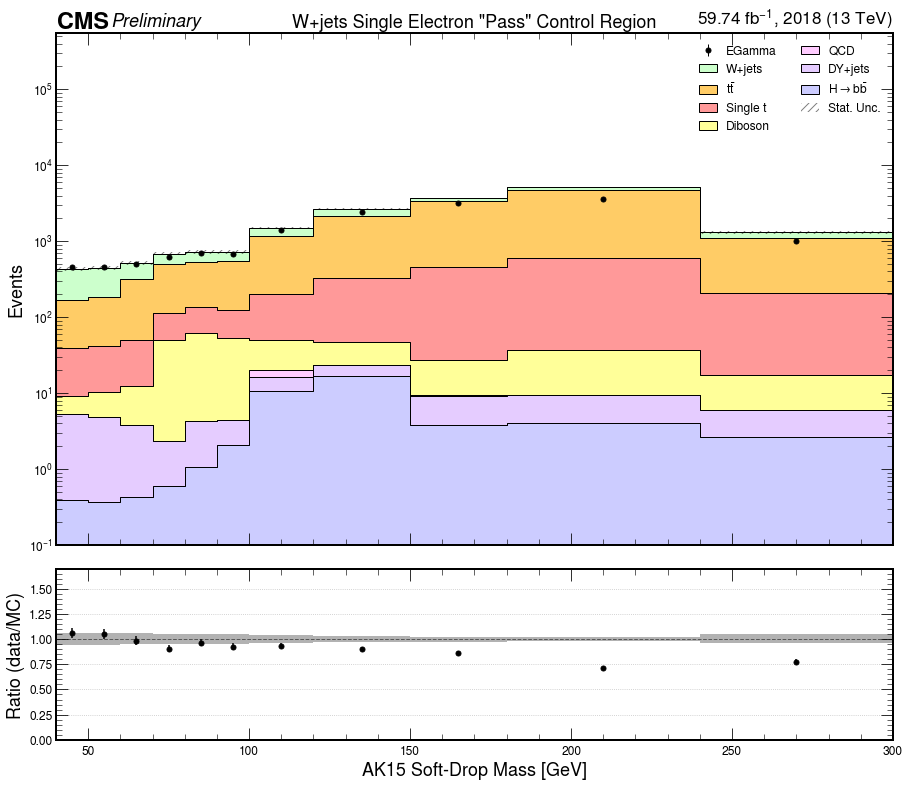

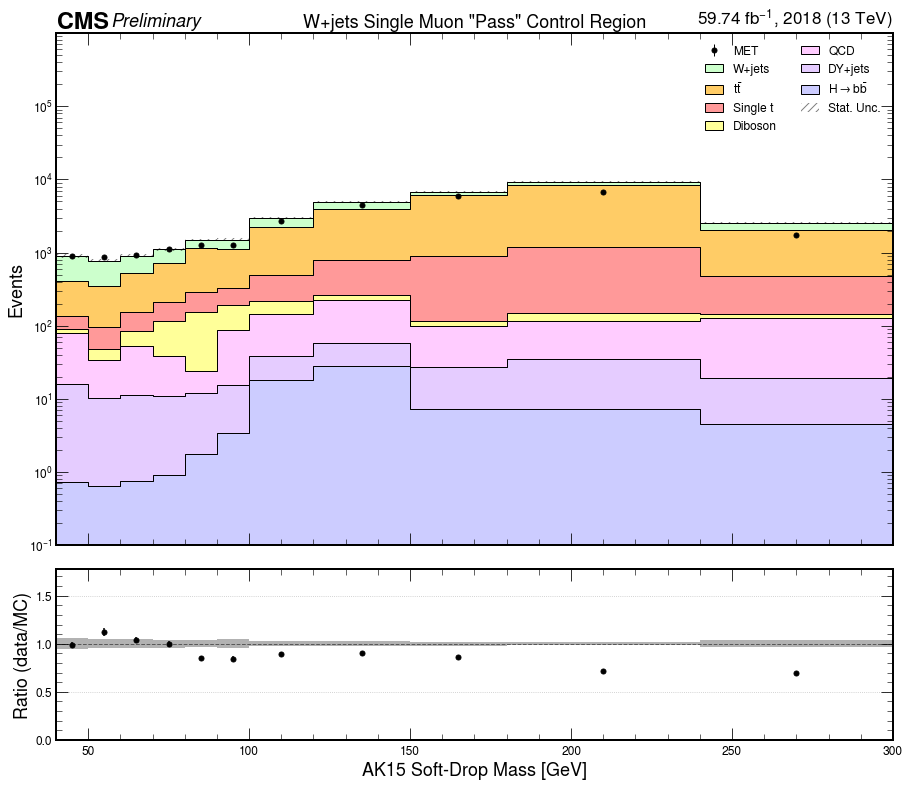

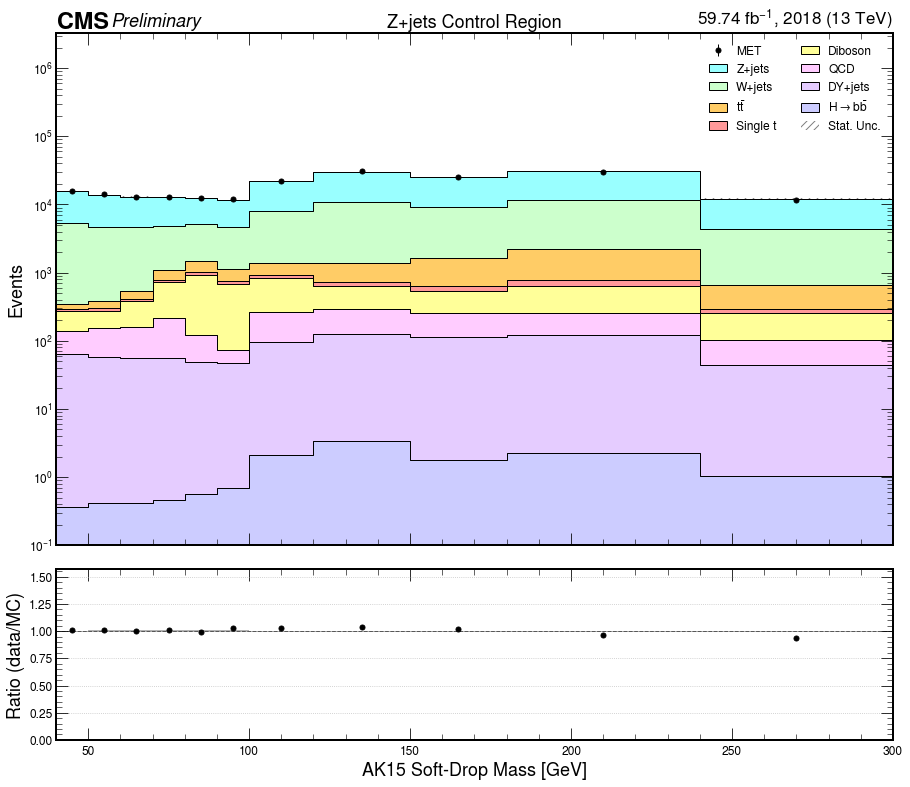

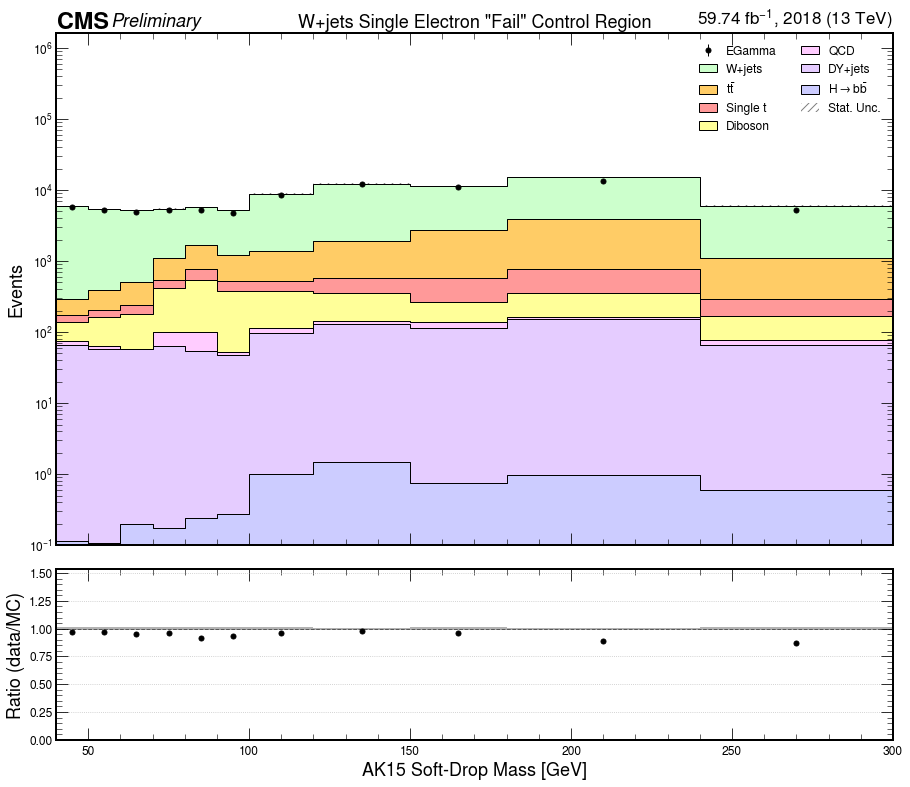

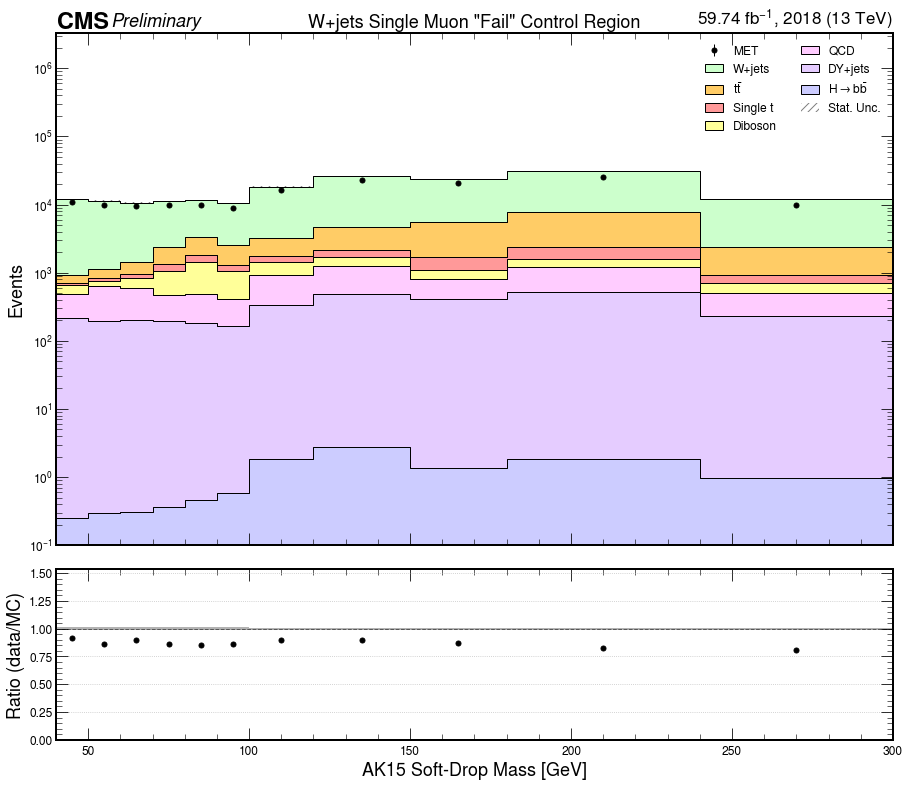

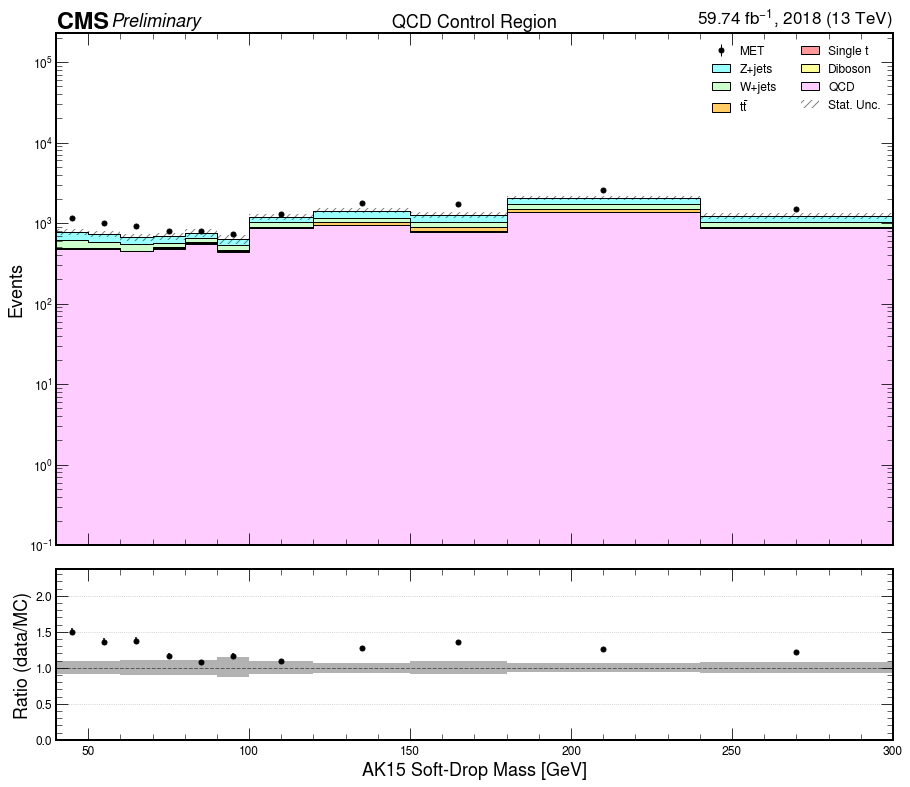

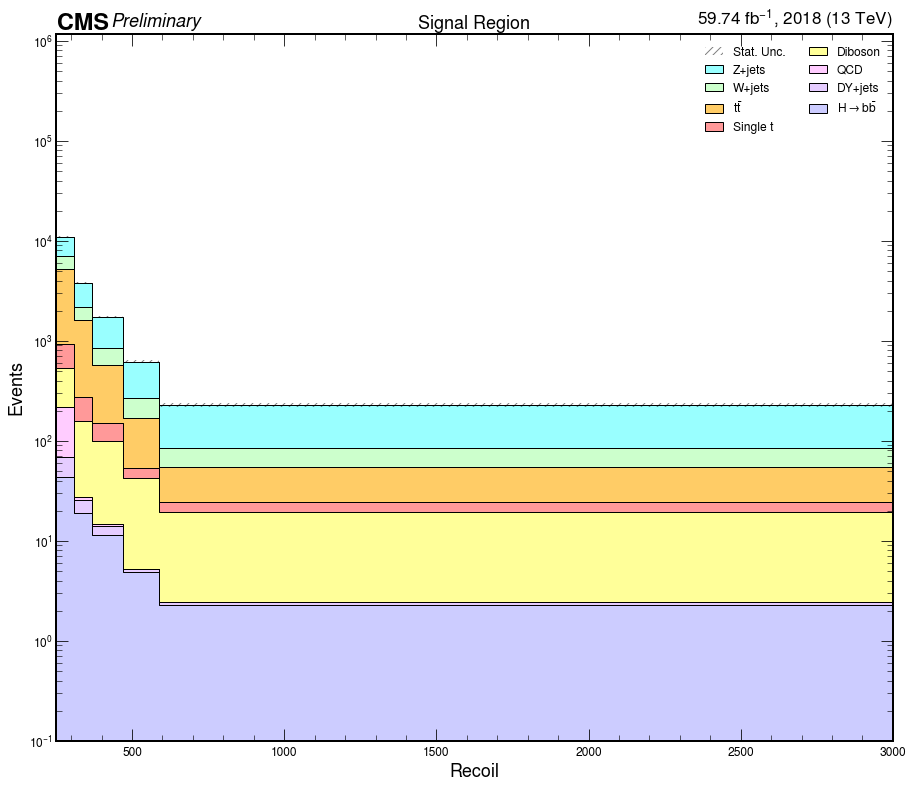

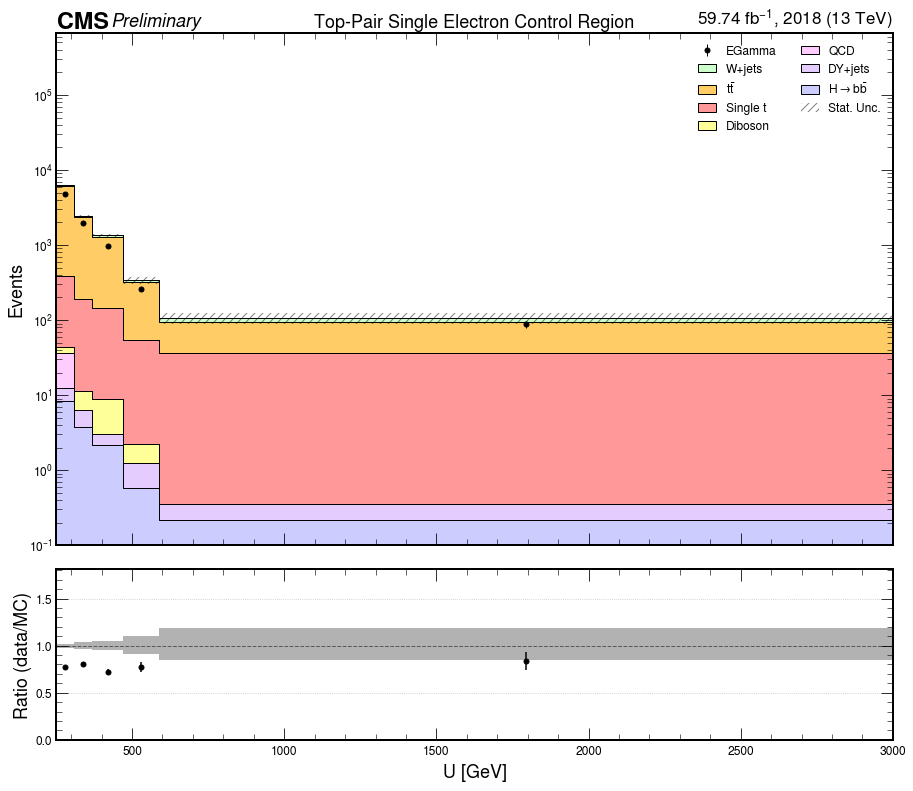

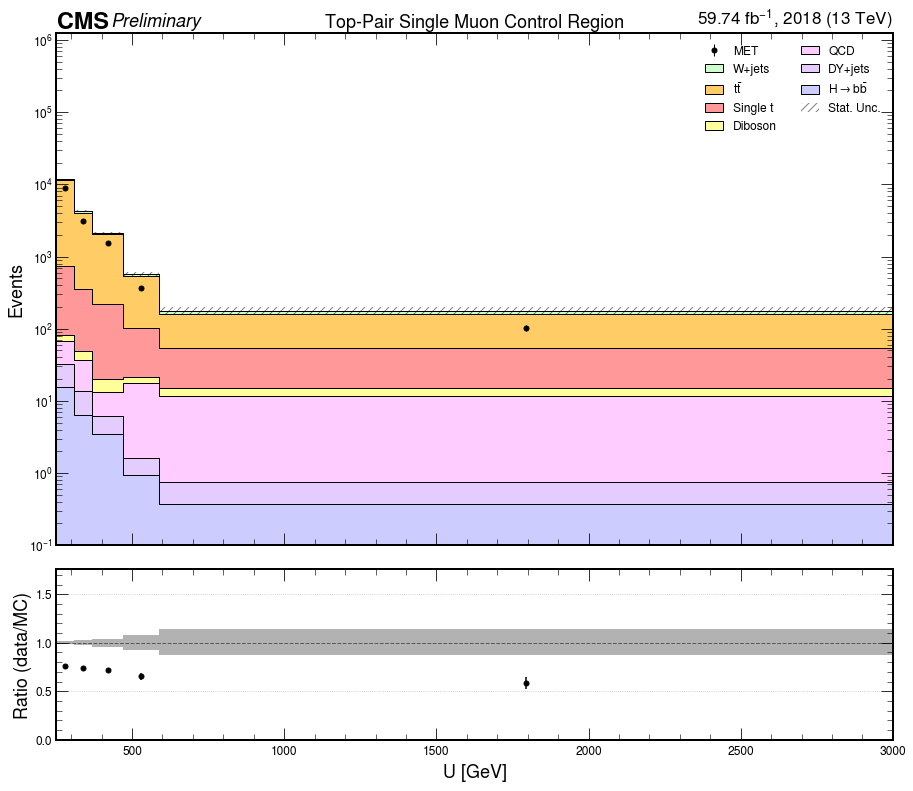

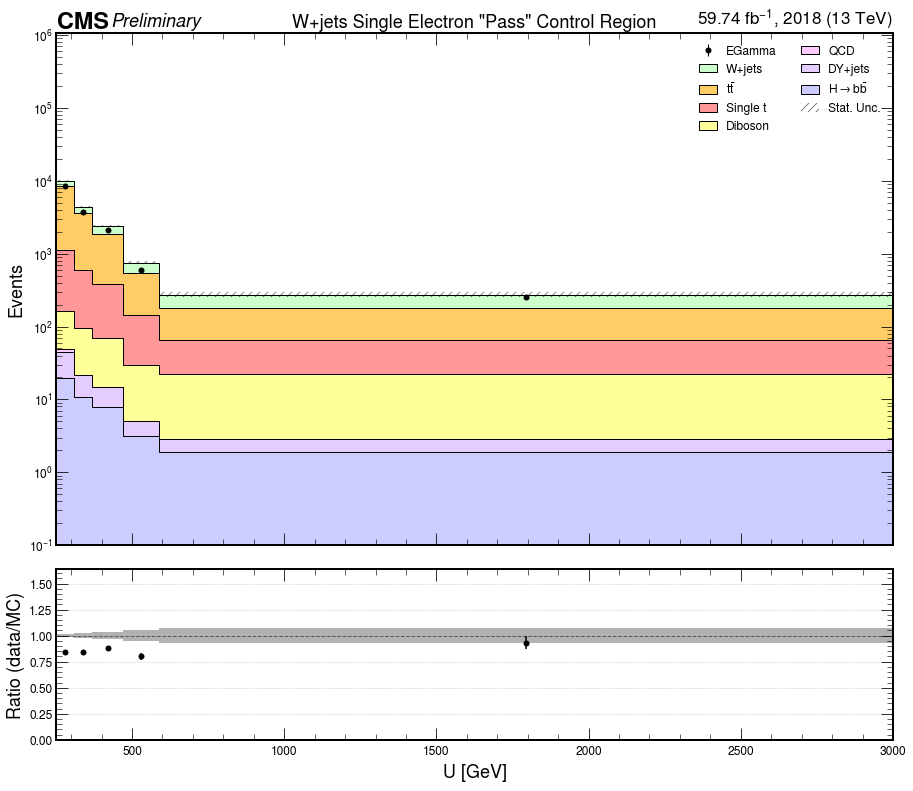

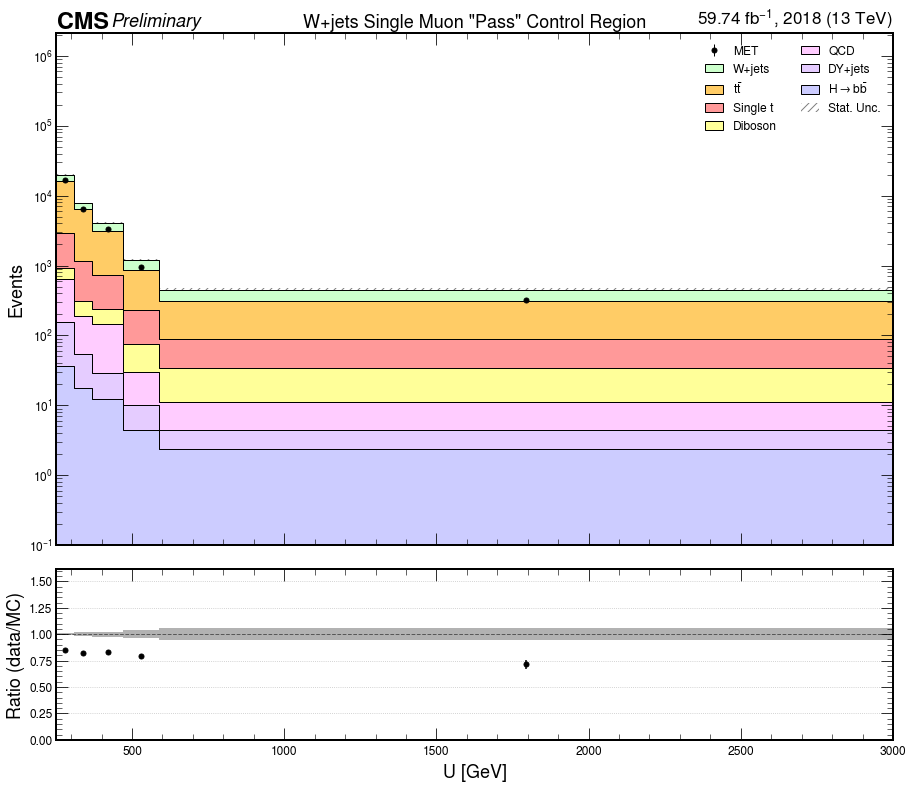

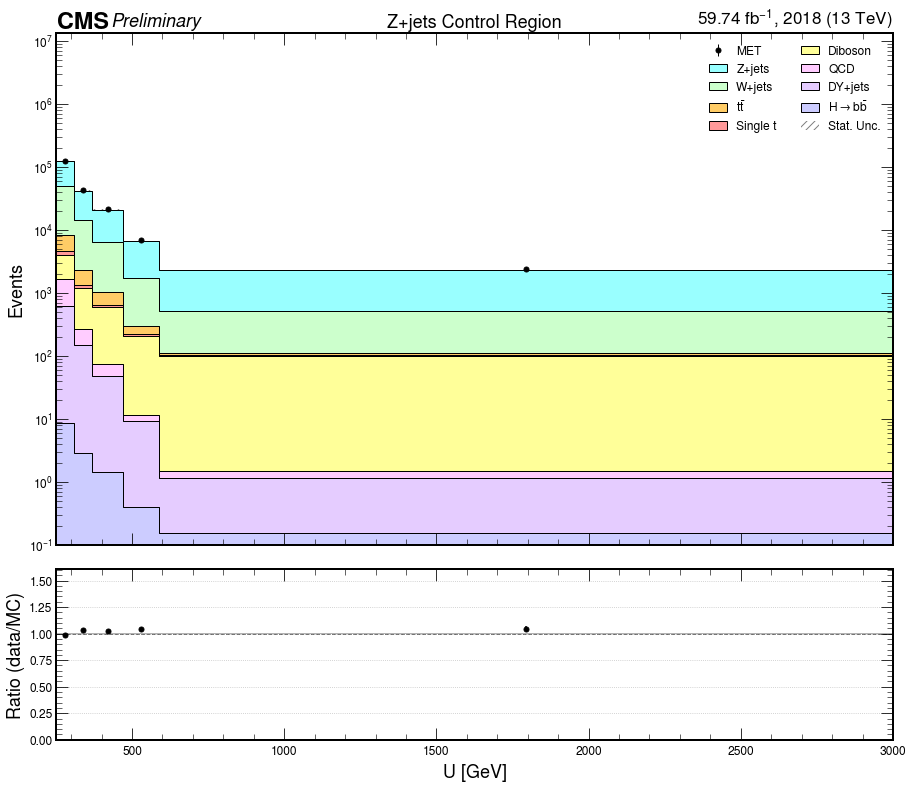

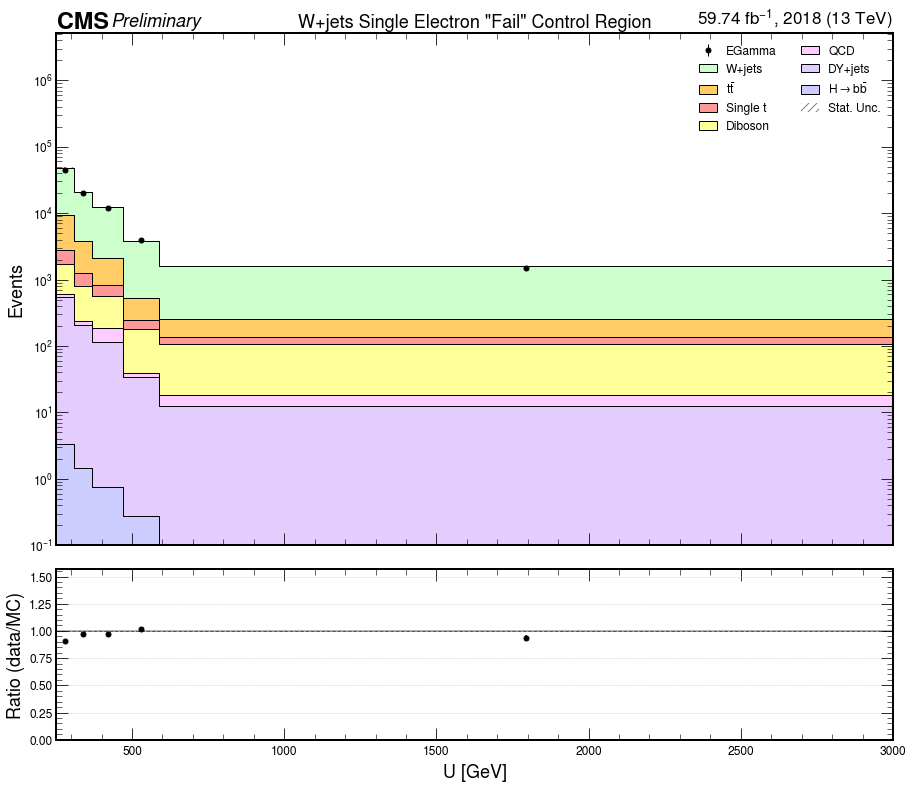

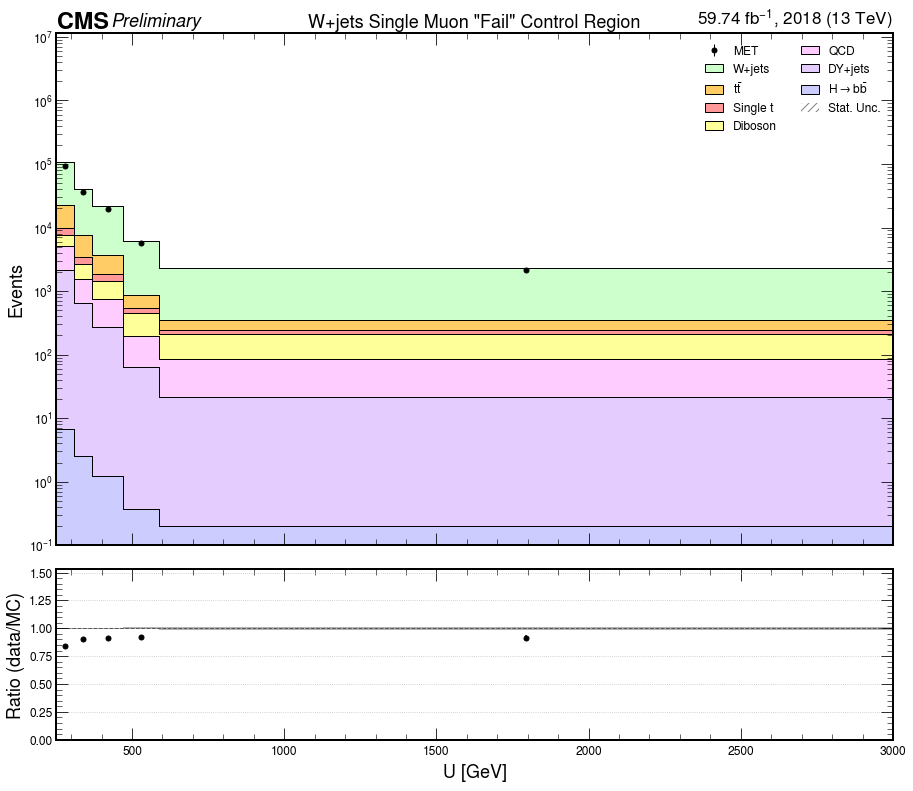

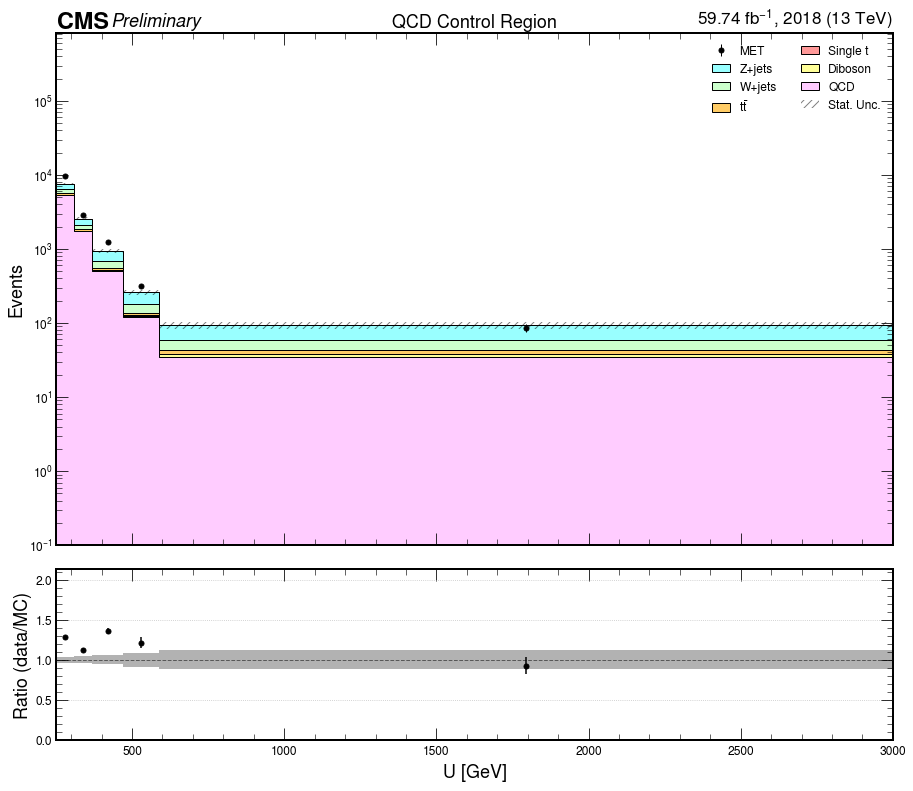

In [13]:
###
# Plot mass or recoil out of template
###

#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler
    
    
def plot_template(category, var):
    varlist=['recoil','fjmass']
    varlist.remove(var)
    
    label={
        'recoil':r'$U$ [GeV]',
        'fjmass':'AK15 Soft-Drop Mass [GeV]'
    }

    binning={
        'pass': pass_binning,
        'fail': fail_binning,
    }

    C={
        'pass':'Pass',
        'fail':'Fail',
        '':''
    }
    regionDict = {
        'sr_pass':'Signal Region',
        'sr_fail':'Z+jets Control Region',
        'wecr_pass':'W+jets Single Electron \"Pass\" Control Region',
        'wecr_fail':'W+jets Single Electron \"Fail\" Control Region',
        'wmcr_pass':'W+jets Single Muon \"Pass\" Control Region',
        'wmcr_fail':'W+jets Single Muon \"Fail\" Control Region',
        'tecr_pass':'Top-Pair Single Electron Control Region',
        'tmcr_pass':'Top-Pair Single Muon Control Region',
        'qcdcr_pass': 'QCD \"Pass\" Control Region',
        'qcdcr_fail': 'QCD \"Fail\" Control Region',
        'qcdcr_': 'QCD Control Region',
        
    }
    colorDict = {
        'DY+jets': '#e5ccff',
        r'$H\rightarrow b\bar{b}$':'#ccccff',
        'QCD': '#ffccff',
        'Diboson': '#ffff99',
        'Single t': '#ff9999',
        r"$t\bar{t}$": '#ffcc66',
        'W+jets': '#ccffcc',
        'Z+jets':'#99ffff'
    }
    #Rebin to pick either pass or fail
    bkg_hists_template=bkg_hists['template']
    process = hist.Cat("process", "Process", sorting="placement")
    cats = ("process",)
    bkg_map = OrderedDict()
    bkg_map[r'$H\rightarrow b\bar{b}$'] = ("Hbb*",)
    bkg_map["DY+jets"] = (["DY+HF","DY+LF"]),
    bkg_map["QCD"] = ("QCD*",)
    bkg_map["Diboson"] = (["WW", "WZ", "ZZ"],)
    bkg_map["Single t"] = (["ST"],)
    bkg_map[r"$t\bar{t}$"] = (["TT"],)
    bkg_map["W+jets"] = (["W+HF","W+LF"],)
    bkg_map["Z+jets"] = (["Z+HF","Z+LF"],)
    bkg_hists_template = bkg_hists_template.group(cats, process, bkg_map)
    signal_hists_template=signal_hists['template']
    data_hists_template=data_hists['template']
    if category is not '':
        bkg_hists_template=bkg_hists_template.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',binning[category]))
        signal_hists_template=signal_hists_template.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',binning[category]))
        data_hists_template=data_hists_template.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',binning[category]))
    
    mc_list={}
    for j in bkg_hists_template.identifiers('region'):
        mc_list[str(j)+'_'+category] = []
        for p in bkg_hists_template.integrate('region',j).identifiers('process'):
            mc_list[str(j)+'_'+category].append(str(p))
            
    for j in bkg_hists_template.identifiers('region'):
        if 'qcd' in str(j) and category!='': continue
        if 'qcd' not in str(j) and category=='': continue
        if 't' in str(j) and category=='fail': continue
        #if 'qcd' in str(j) and category=='fail': continue
        #if not (str(j) == 'tecr'): continue
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        #colors = ['#99ffff', '#ccffcc', '#ffcc66', '#ff9999', '#ffff99', '#ffccff', '#ccccff','#e5ccff']
        colors=[]
        for x in mc_list[str(j)+'_'+category]:
            colors.append(colorDict[x])
        colors.reverse()


        if ('sr' in str(j) and category=='pass'):
            fig, ax = plt.subplots(1, 1, figsize=(15,13))
        else:
            fig, (ax, rax) = plt.subplots(2, 1, figsize=(15,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))

        plot.plot1d(bkg_hists_template.integrate('region',j).integrate('systematic','nominal').sum(varlist[0],'ZHbbvsQCD'),
                        overlay="process",
                        ax=ax,
                        clear=False,
                        stack=True,
                        fill_opts=fill_opts,
                        error_opts=error_opts
                        )
    
        if not ('sr' in str(j) and category=='pass'):

            plot.plot1d(data_hists_template.integrate('region',j).integrate('systematic','nominal').sum(varlist[0],'ZHbbvsQCD')[data[year][str(j)]],            
                        overlay="process",
                        ax=ax,
                        clear=False,
                        error_opts=data_err_opts
                        )
        
            plot.plotratio(data_hists_template.integrate('region',j).integrate('systematic','nominal').sum(varlist[0],'ZHbbvsQCD').integrate('process',data[year][str(j)]), 
                       bkg_hists_template.integrate('region',j).integrate('systematic','nominal').sum(varlist[0],'ZHbbvsQCD').sum('process'),
                       ax=rax,
                       #overflow='over',
                       error_opts=data_err_opts,
                       denom_fill_opts={},
                       guide_opts={},
                       unc='num'
                       )
        
            rax.set_ylabel('Ratio (data/MC)')
            rax.set_ylim(0,abs(rax.get_ylim()[1])*1.5)
            rax.grid(axis='y')
            rax.set_xlabel(label[var])

        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        ax.set_ylim(.1, ax.get_ylim()[1]*100.)
        #leg = ax.legend(ncol=2, loc='best')
        handles, labels = ax.get_legend_handles_labels()
        order = list(range(len(labels)-1))
        order.insert(0, len(labels)-1)
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                     loc='upper right', fontsize=12, ncol=2)


        #coffee = plt.text(0., 1., regionDict[str(j)+'_'+category], fontsize=15, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
        #lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        if not ('sr' in str(j) and category=='pass'):
            ax.set(xlabel=None)
        ax.set_title(regionDict[str(j)+'_'+category], loc='center', fontsize=18)
        hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=18)
        hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=18)
        os.system('mkdir -p ../plots/darkhiggs/prefit/'+year+'/')
        plot_path = os.path.abspath('../plots/darkhiggs/prefit/'+year+'/') 
        plot_name = 'stack_'+str(j)+'_'+category+'_'+var+'.png'
        fig.savefig(os.path.join(plot_path, plot_name))
        
plot_template('pass', 'fjmass')
plot_template('fail', 'fjmass')
plot_template('', 'fjmass')
plot_template('pass', 'recoil')
plot_template('fail', 'recoil')
plot_template('', 'recoil')

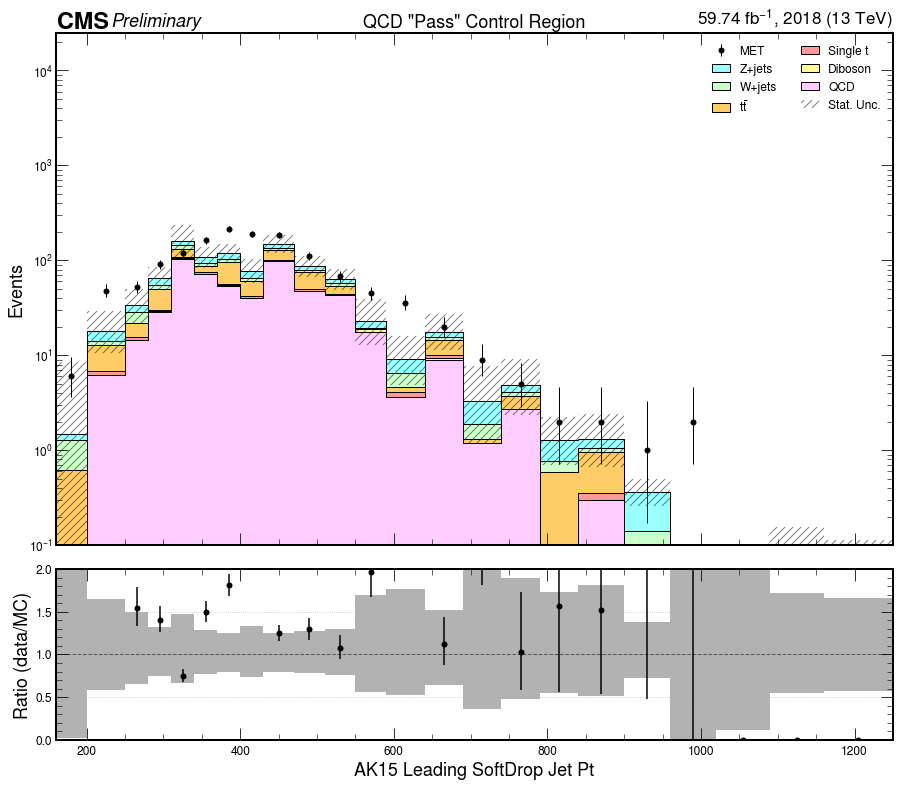

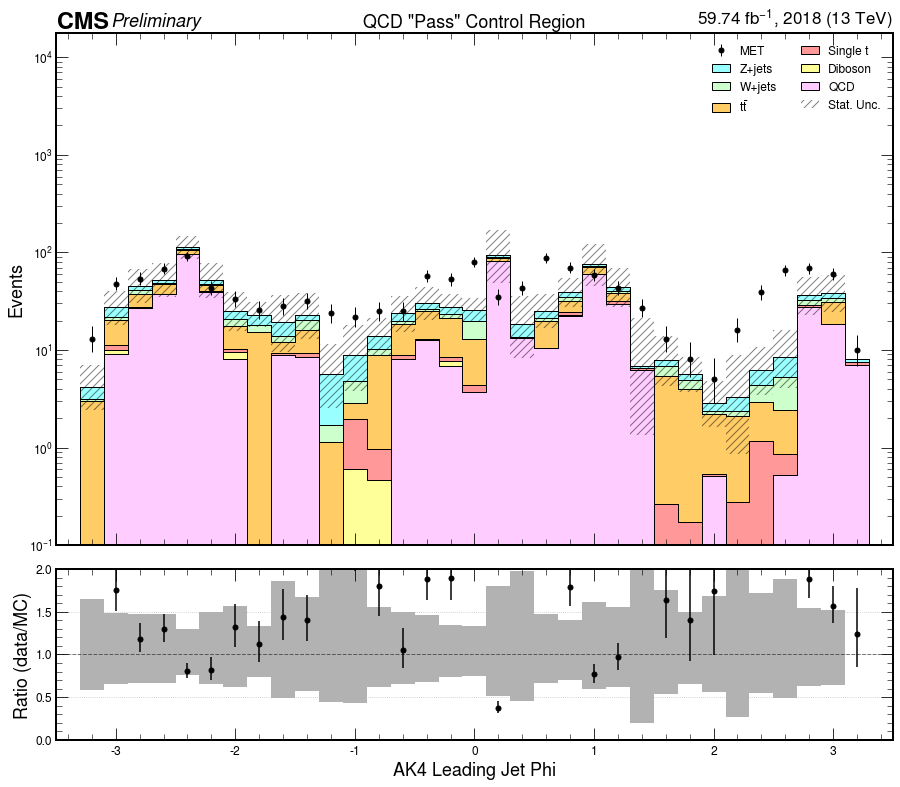

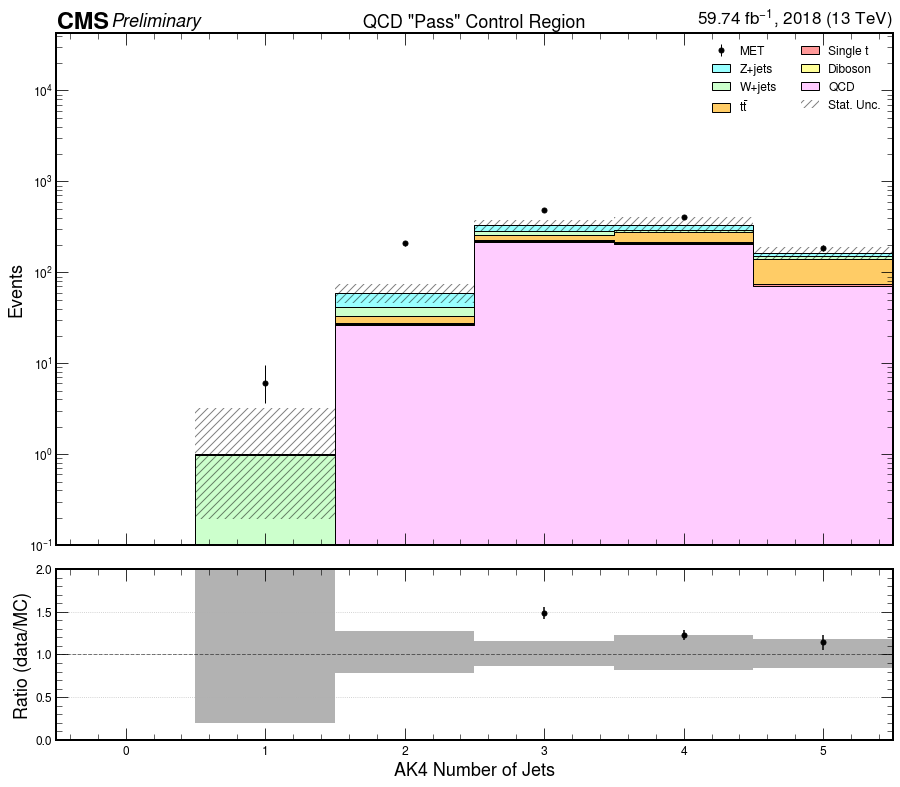

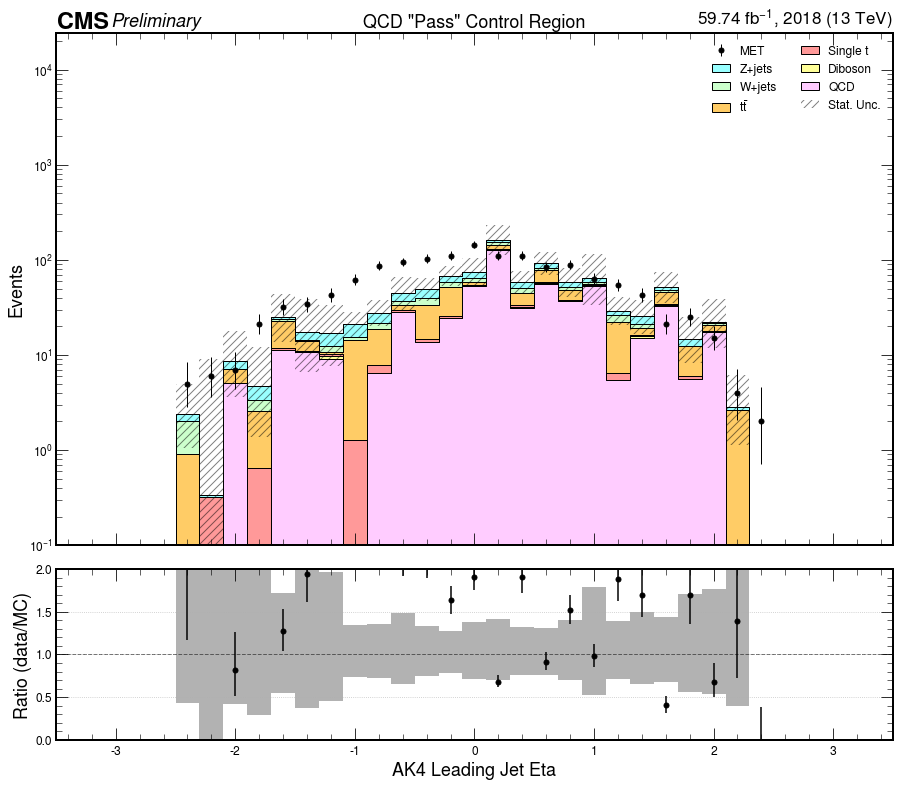

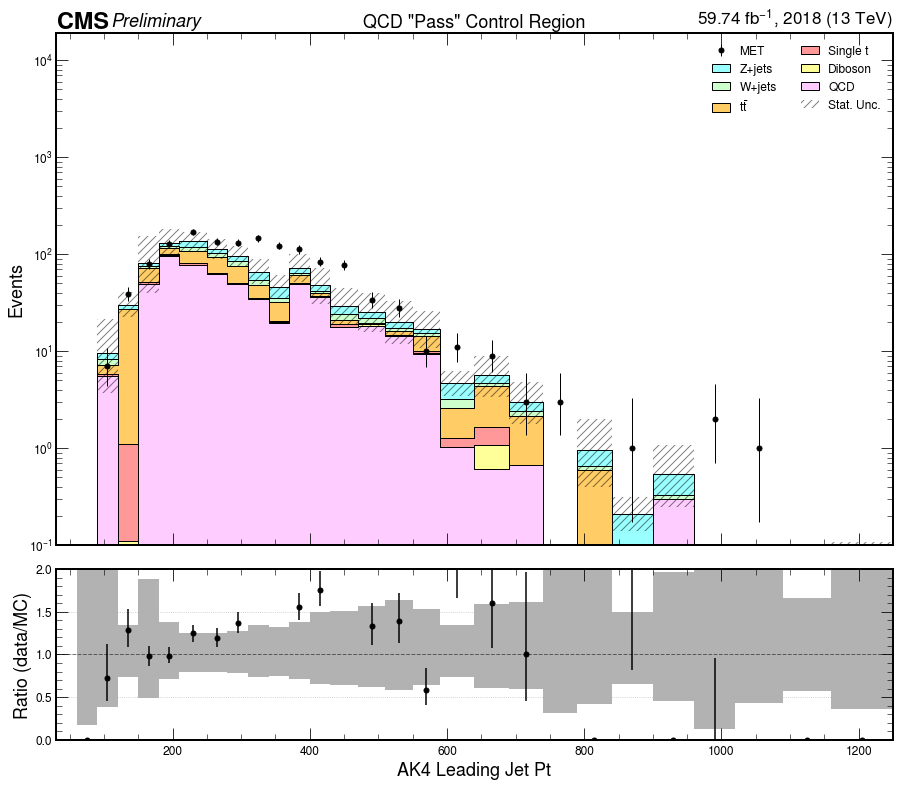

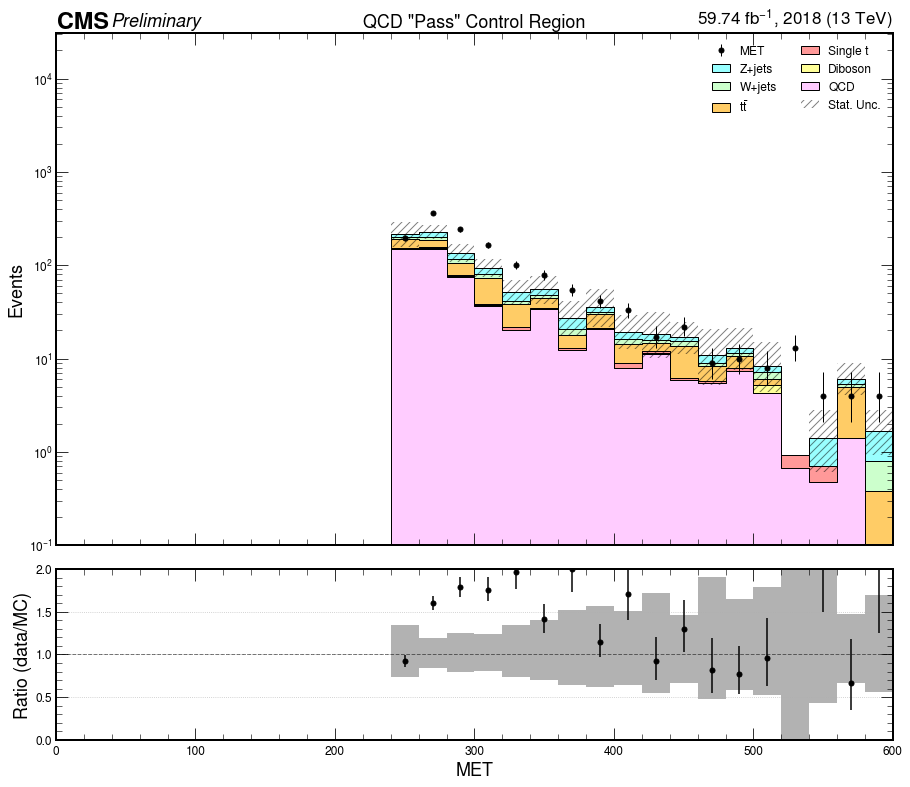

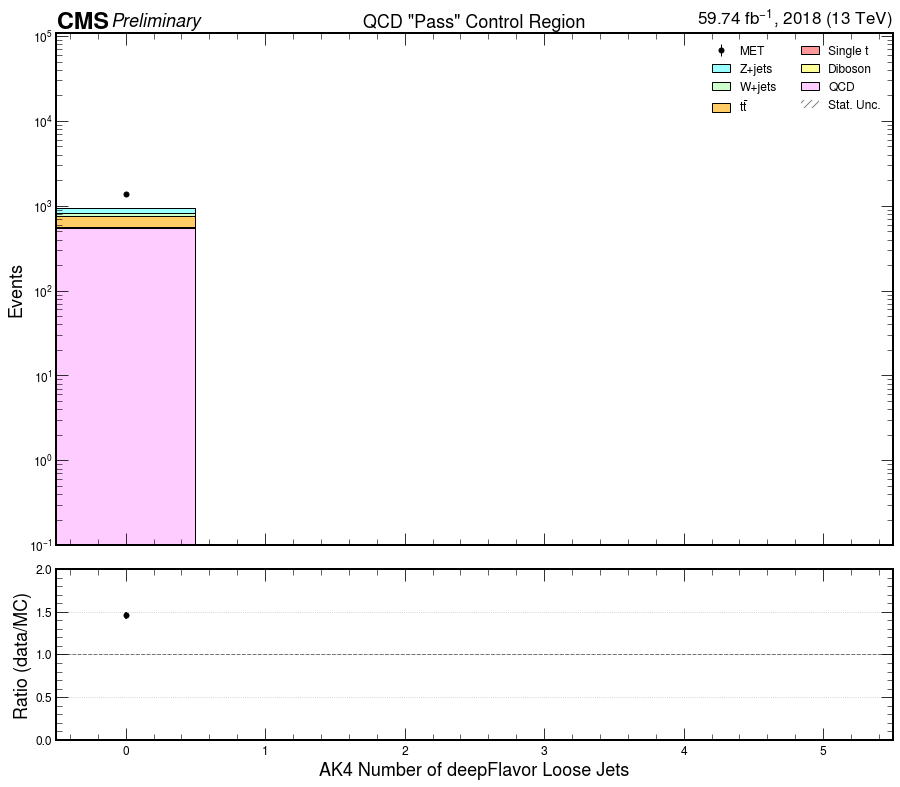

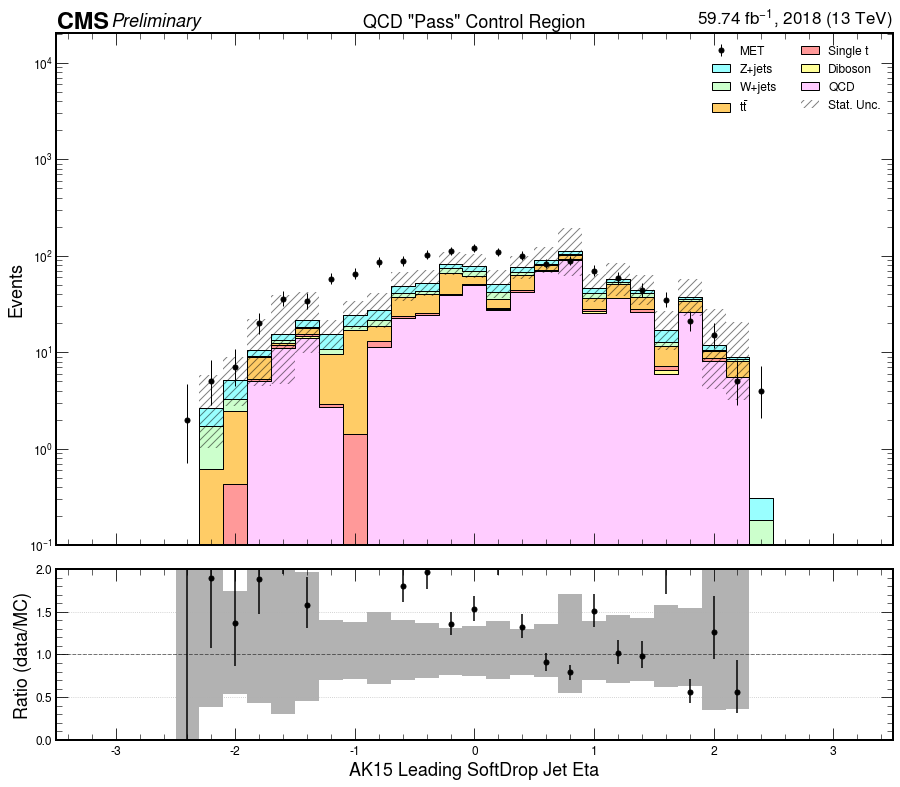

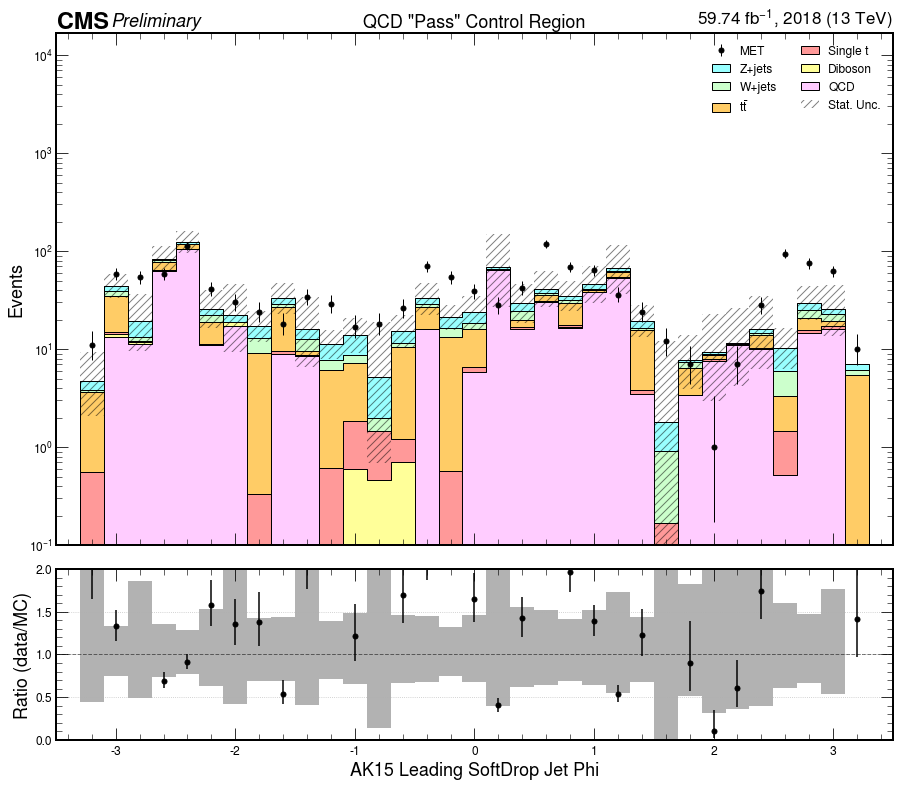

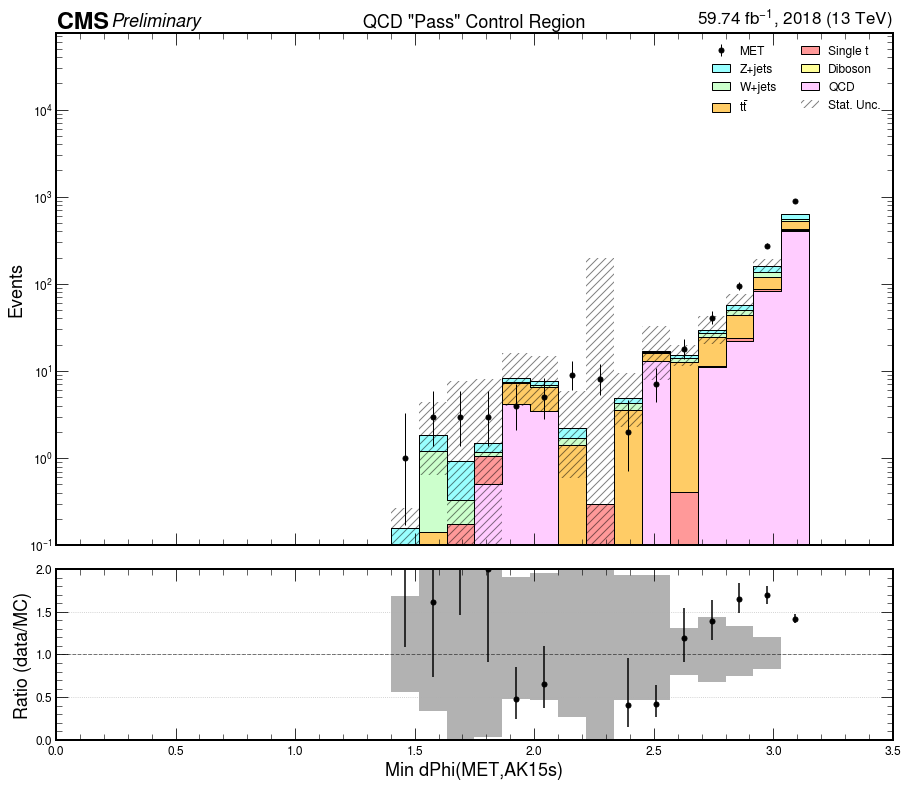

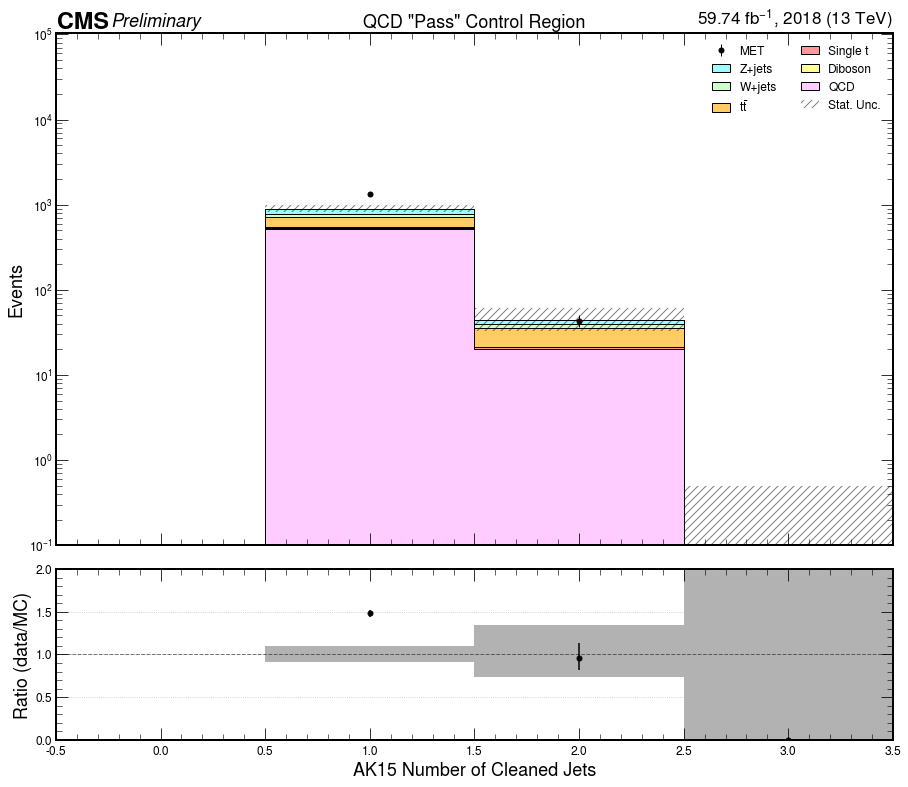

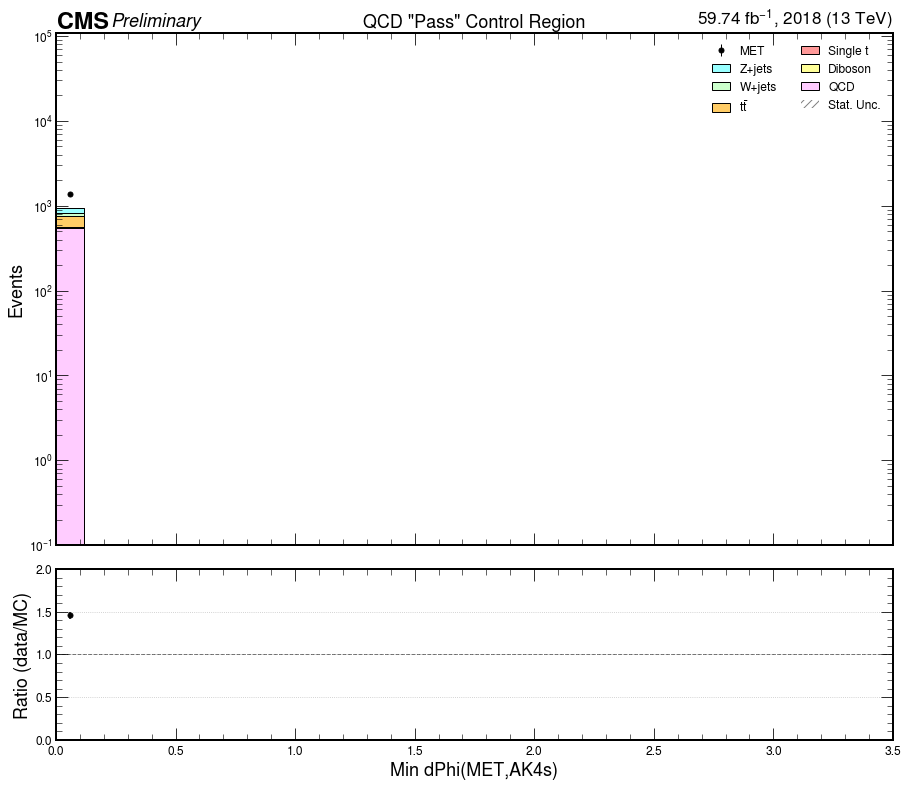

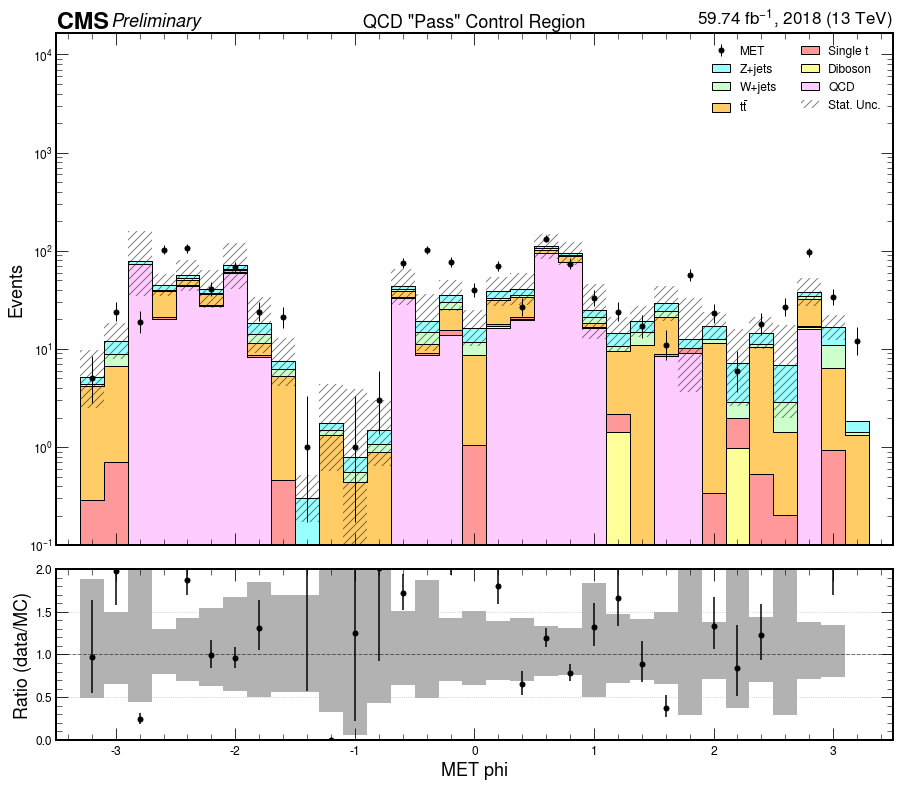

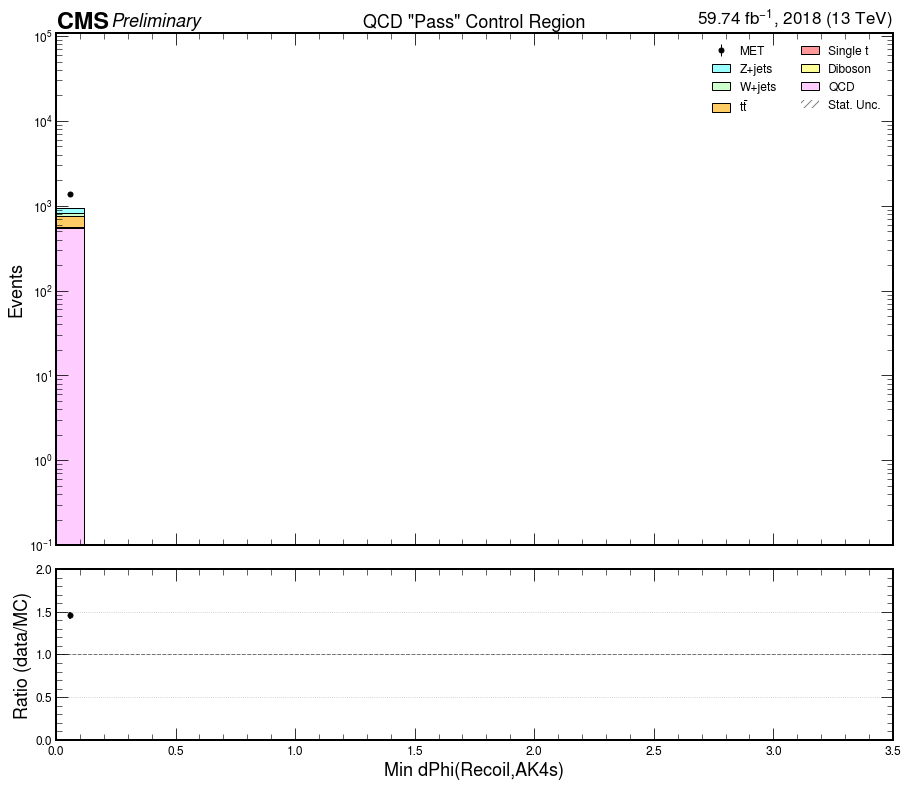

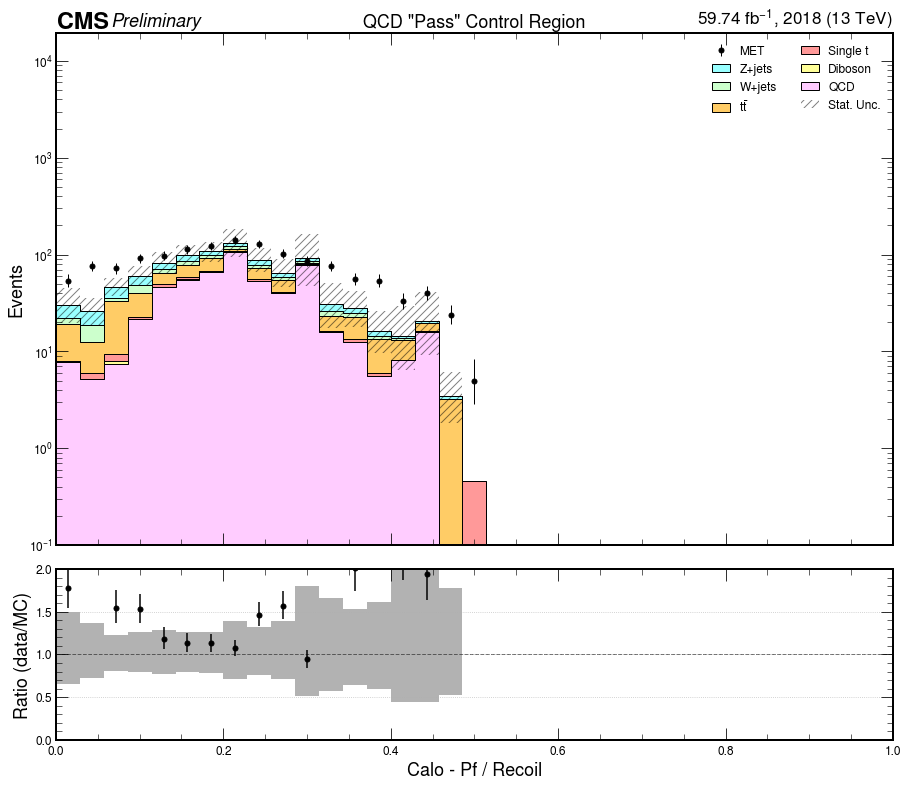

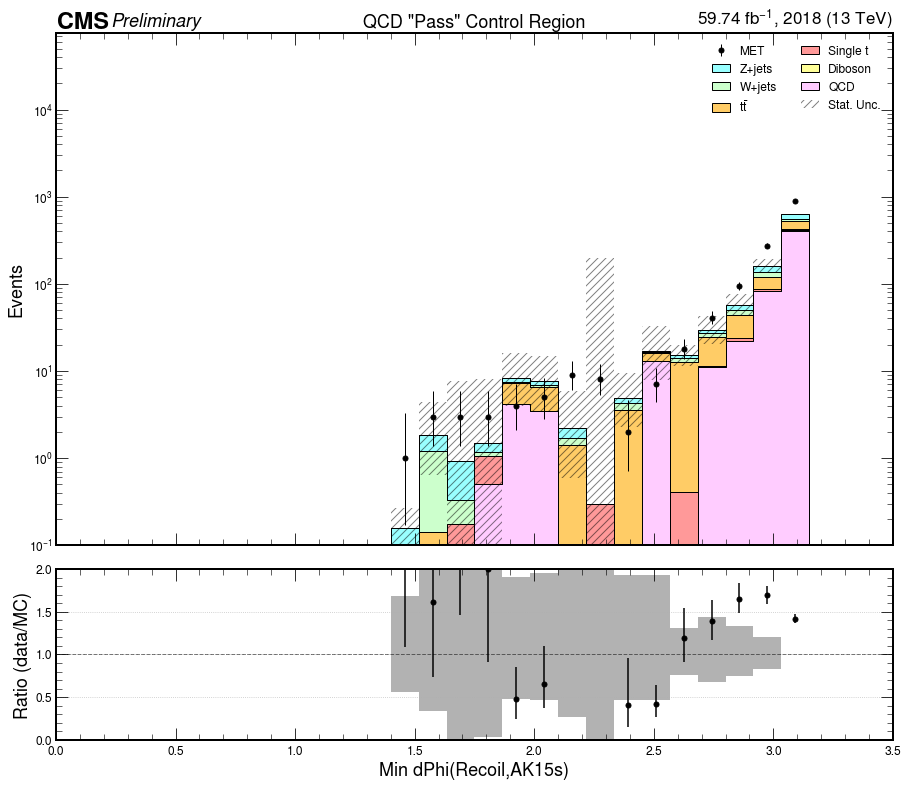

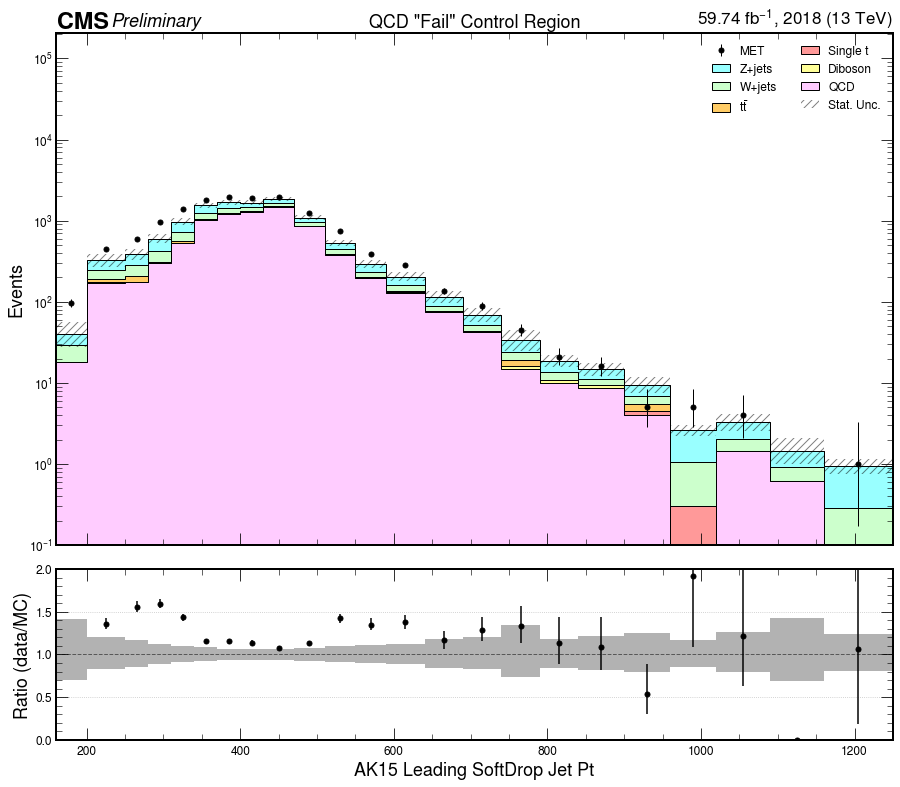

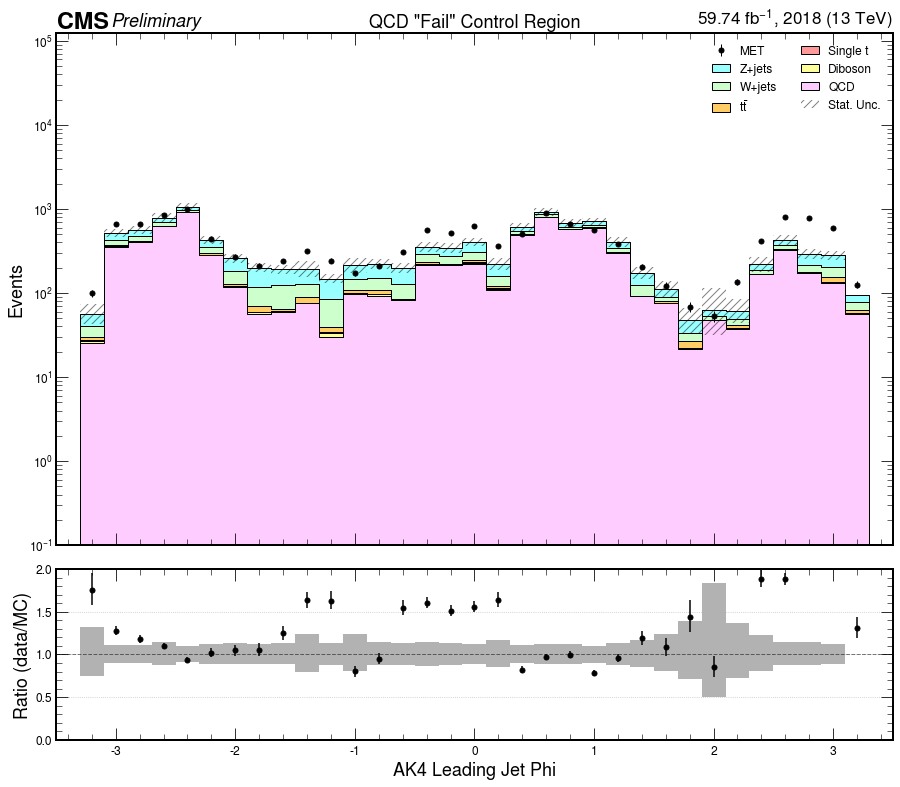

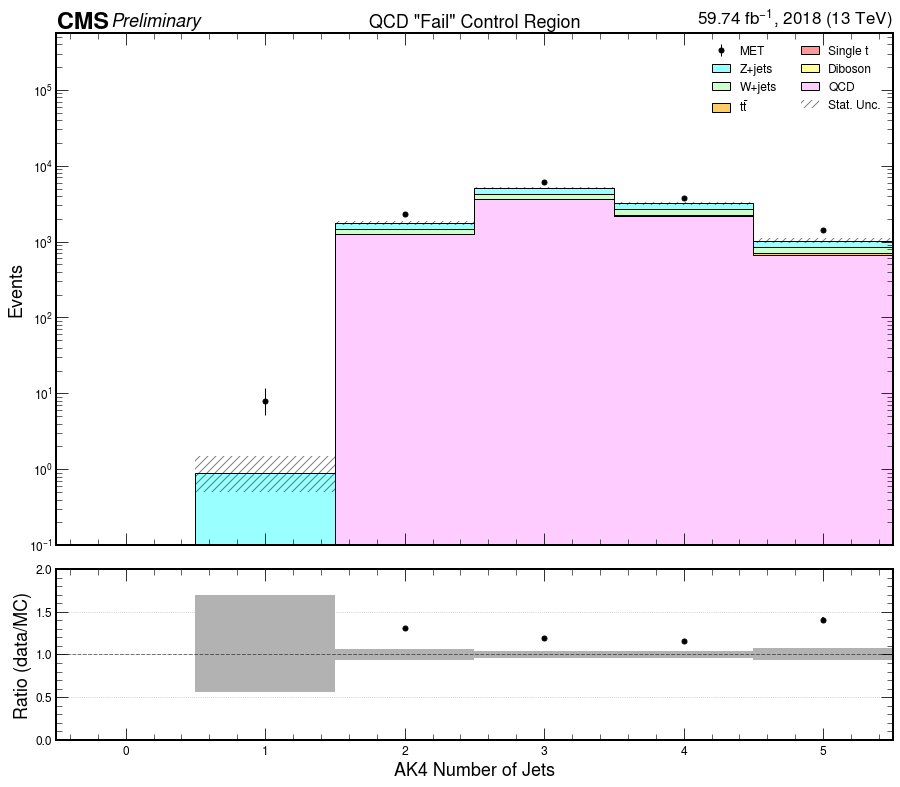

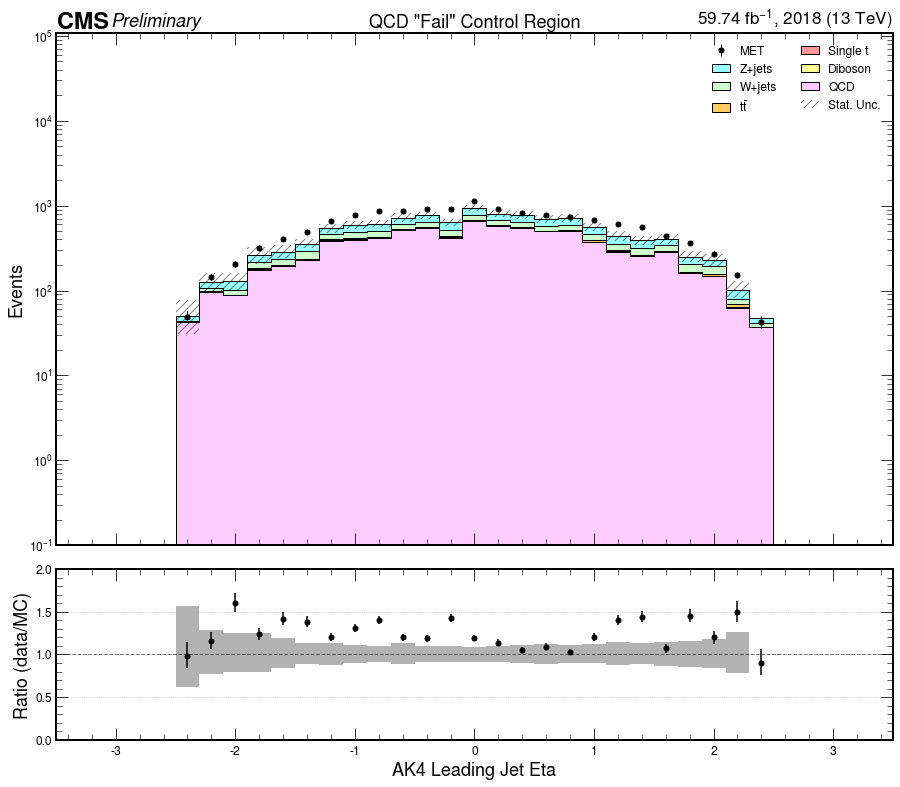

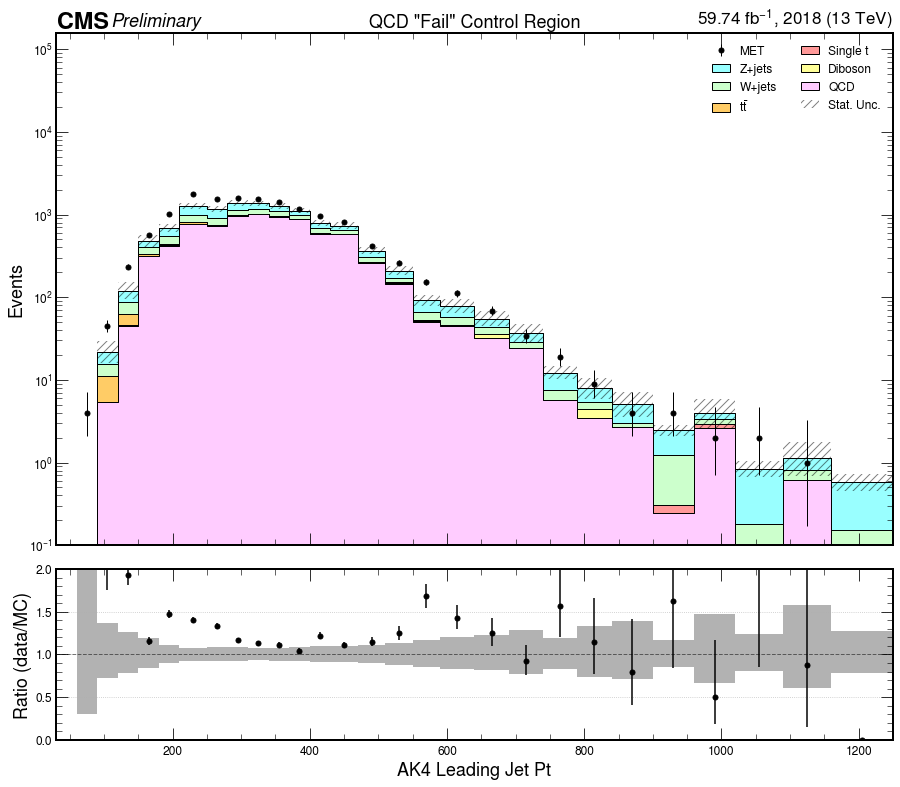

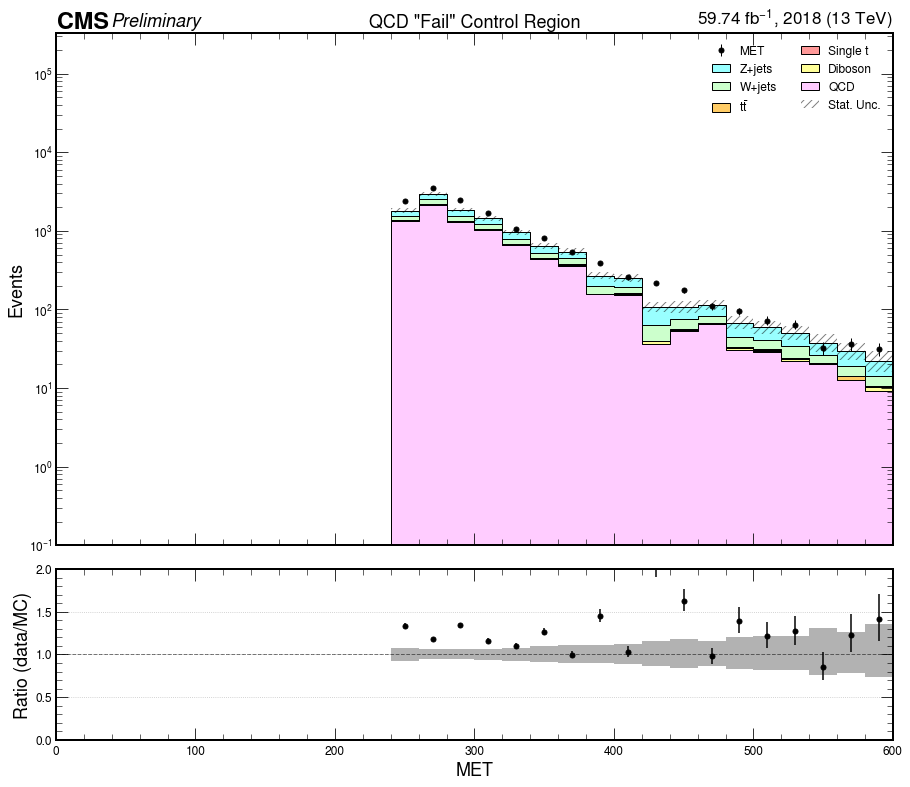

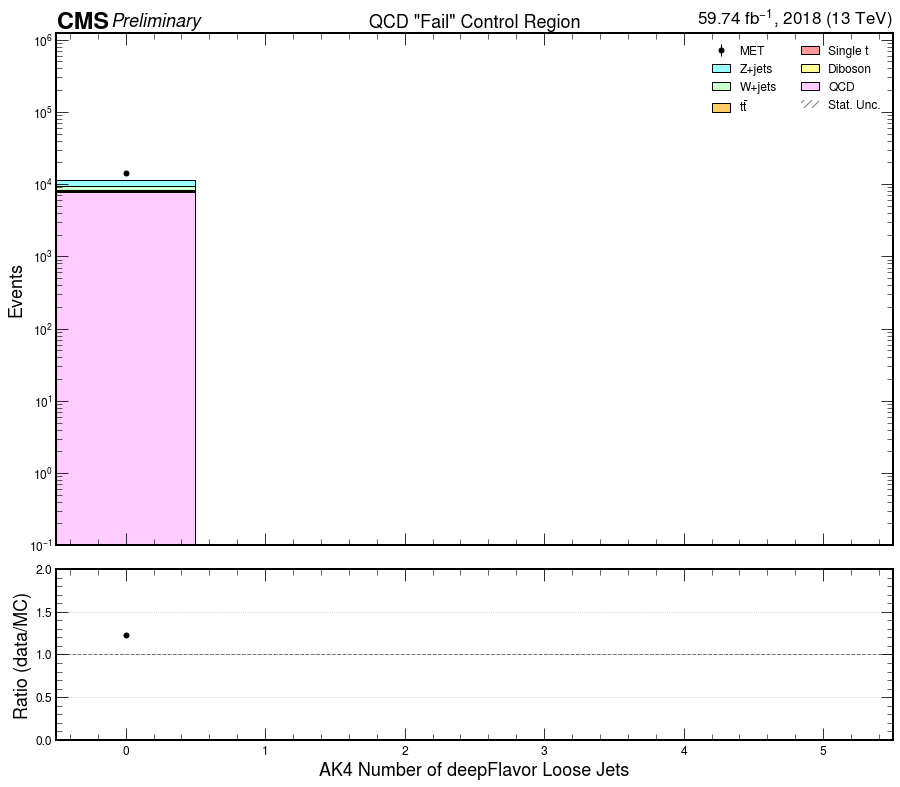

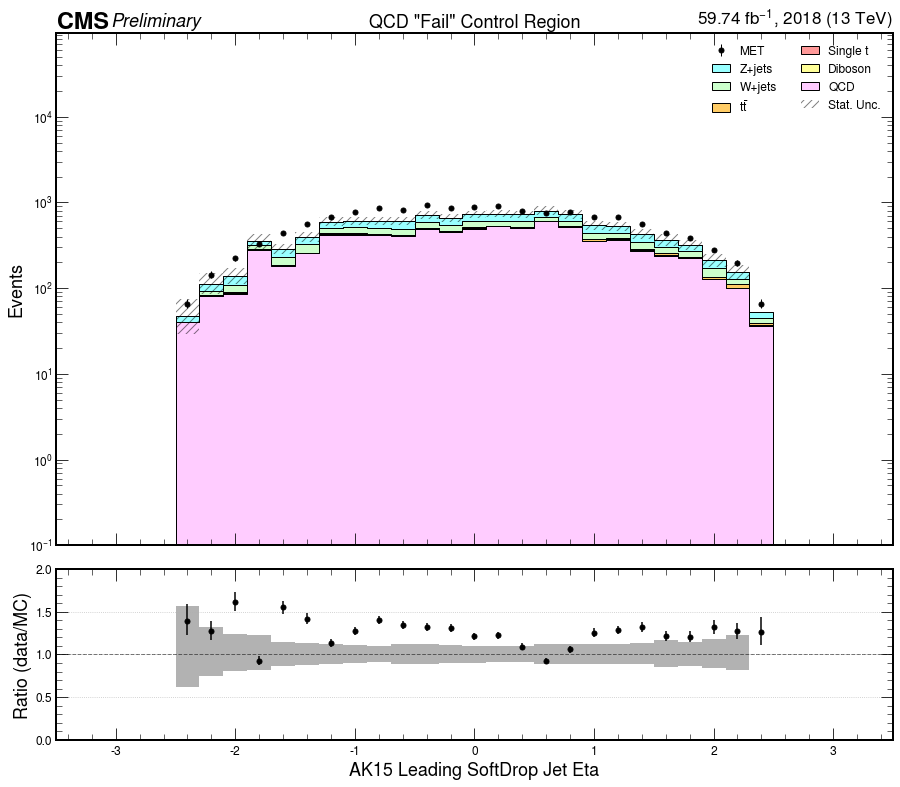

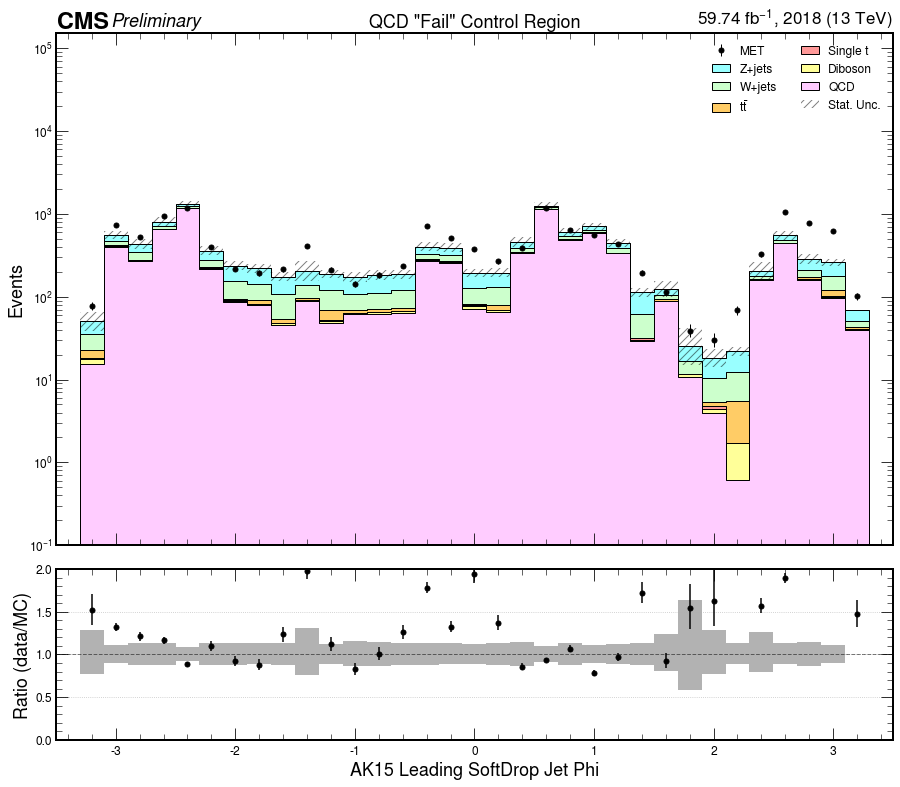

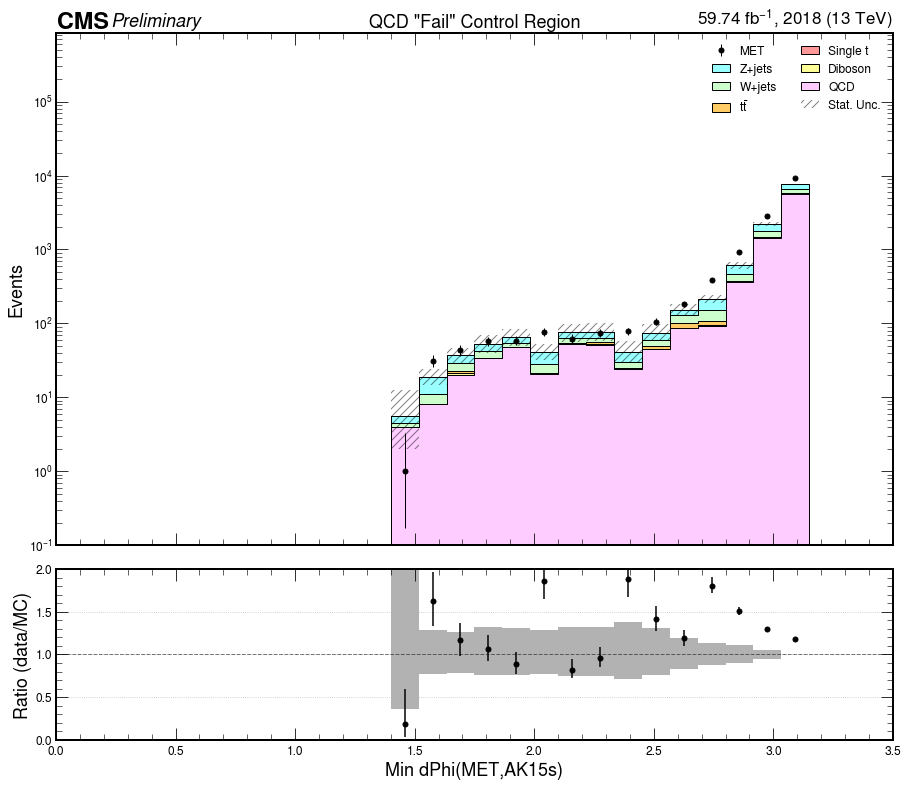

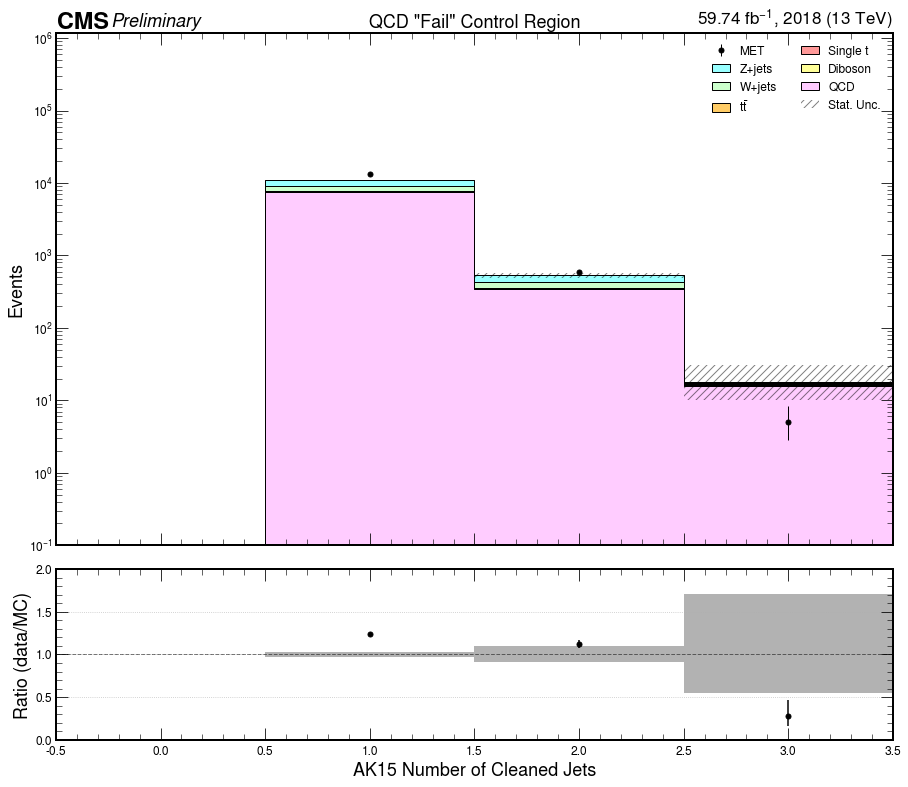

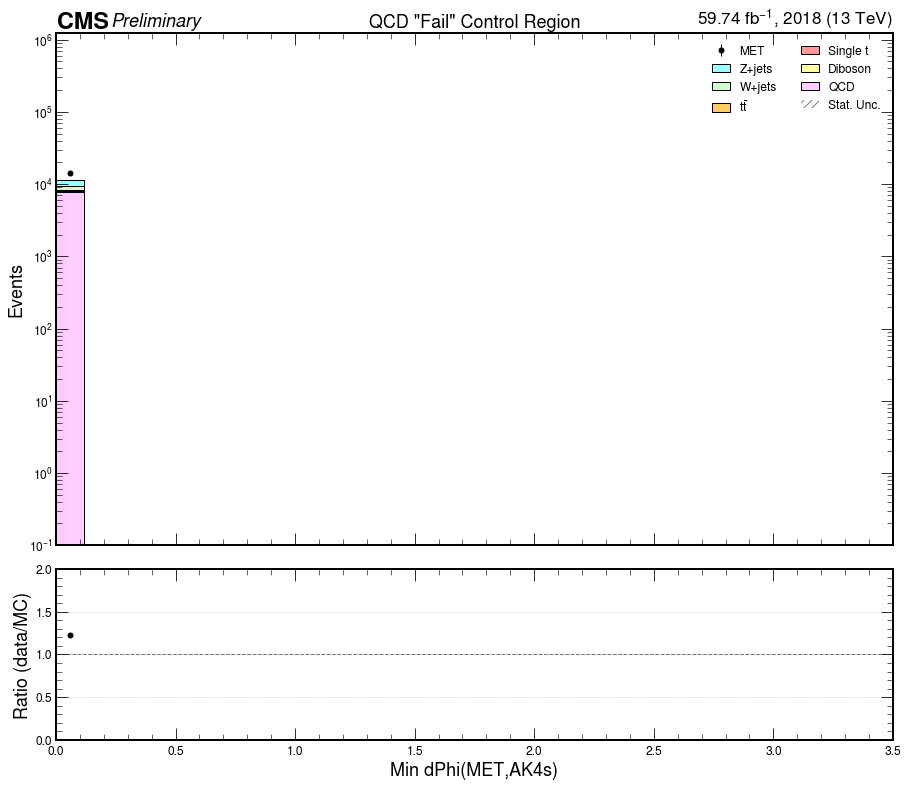

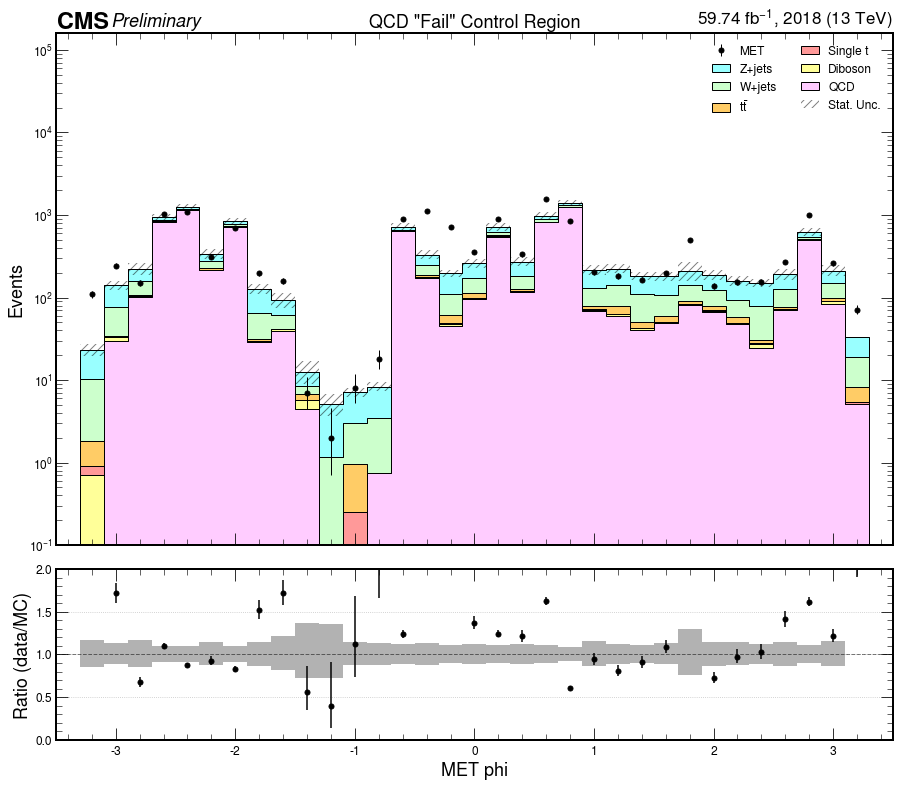

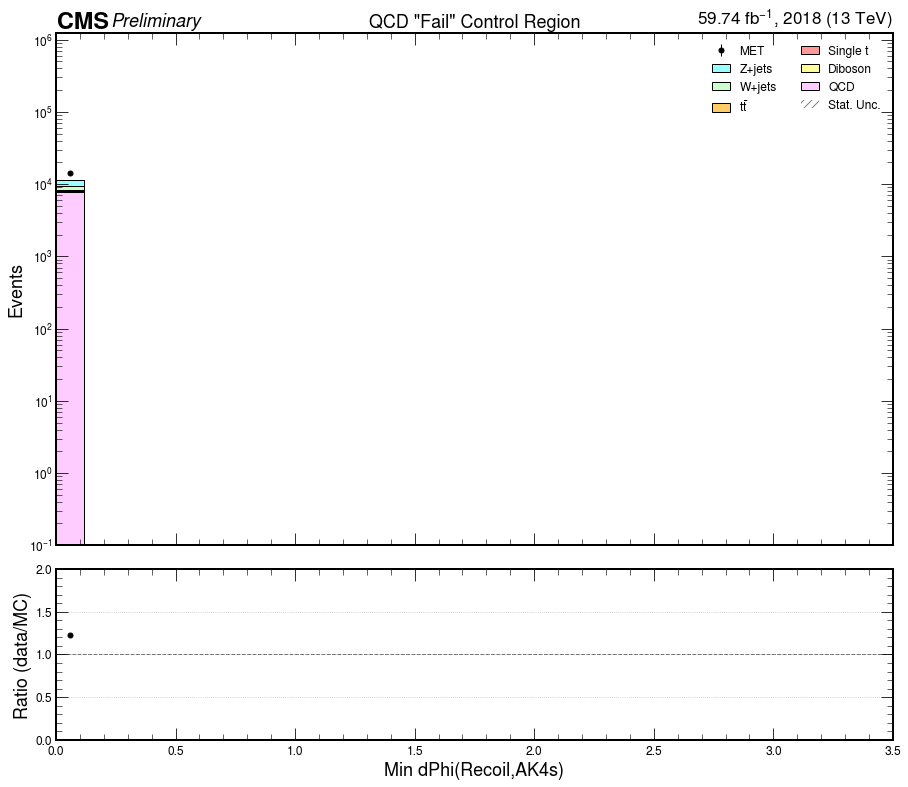

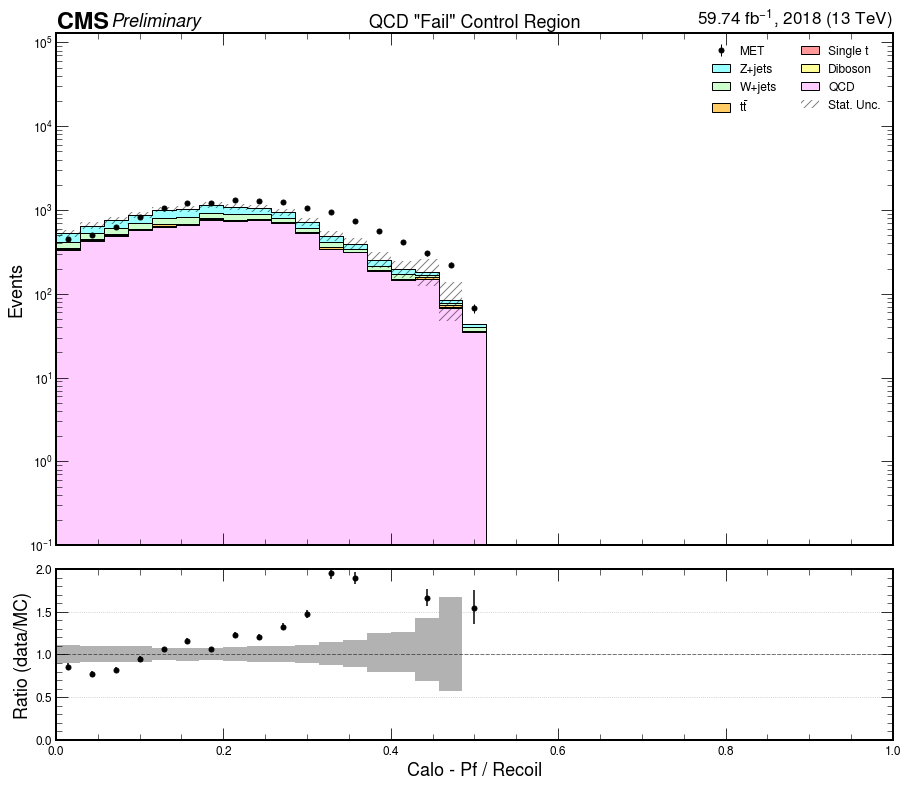

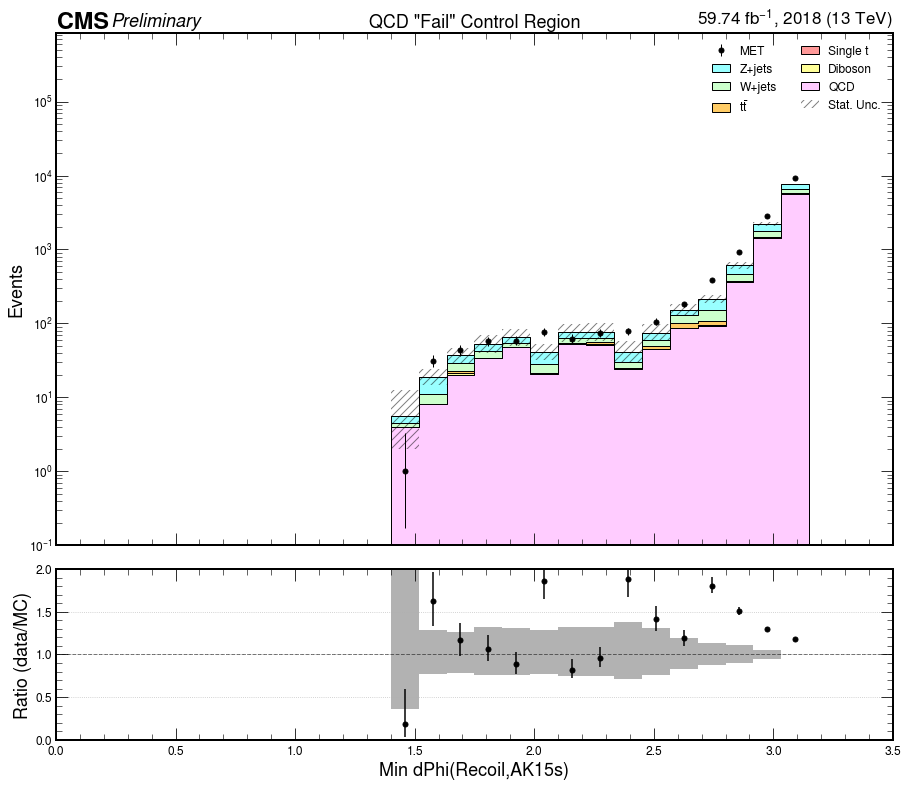

In [4]:
###
# Plot other variables
###
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
    
from cycler import cycler
    
    
def plot_var(category, var=None):
    
    binning={
        'pass': pass_binning,
        'fail': fail_binning,
    }

    C={
        'pass':'Pass',
        'fail':'Fail',
        '':''
    }
    regionDict = {
        'sr_pass':'Signal Region',
        'sr_fail':'Z+jets Control Region',
        'wecr_pass':'W+jets Single Electron \"Pass\" Control Region',
        'wecr_fail':'W+jets Single Electron \"Fail\" Control Region',
        'wmcr_pass':'W+jets Single Muon \"Pass\" Control Region',
        'wmcr_fail':'W+jets Single Muon \"Fail\" Control Region',
        'tecr_pass':'Top-Pair Single Electron Control Region',
        'tmcr_pass':'Top-Pair Single Muon Control Region',
        'qcdcr_pass': 'QCD \"Pass\" Control Region',
        'qcdcr_fail': 'QCD \"Fail\" Control Region',
    }
    colorDict = {
        'DY+jets': '#e5ccff',
        r'$H\rightarrow b\bar{b}$':'#ccccff',
        'QCD': '#ffccff',
        'Diboson': '#ffff99',
        'Single t': '#ff9999',
        r"$t\bar{t}$": '#ffcc66',
        'W+jets': '#ccffcc',
        'Z+jets':'#99ffff'
    }
    for key in bkg_hists.keys():
        
        if key=='sumw': continue
        if key=='template': continue
        if key=='cutflow': continue
        if key=='ZHbbvsQCD': continue
        if var and var not in key: continue
        
        #Rebin to pick either pass or fail
        bkg_hists_var=bkg_hists[key]
        process = hist.Cat("process", "Process", sorting="placement")
        cats = ("process",)
        bkg_map = OrderedDict()
        bkg_map[r'$H\rightarrow b\bar{b}$'] = ("Hbb*",)
        bkg_map["DY+jets"] = (["DY+HF","DY+LF"]),
        bkg_map["QCD"] = ("QCD*",)
        bkg_map["Diboson"] = (["WW", "WZ", "ZZ"],)
        bkg_map["Single t"] = (["ST"],)
        bkg_map[r"$t\bar{t}$"] = (["TT"],)
        bkg_map["W+jets"] = (["W+HF","W+LF"],)
        bkg_map["Z+jets"] = (["Z+HF","Z+LF"],)
        bkg_hists_var = bkg_hists_var.group(cats, process, bkg_map)
        signal_hists_var=signal_hists[key]
        data_hists_var=data_hists[key]
        if category is not '':
            bkg_hists_var=bkg_hists_var.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',binning[category]))
            signal_hists_var=signal_hists_var.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',binning[category]))
            data_hists_var=data_hists_var.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',binning[category]))
            
        
        mc_list={}
        for j in bkg_hists_var.identifiers('region'):
            mc_list[str(j)+'_'+category] = []
            for p in bkg_hists_var.integrate('region',j).identifiers('process'):
                mc_list[str(j)+'_'+category].append(str(p))
            
        for j in bkg_hists_var.identifiers('region'):
            if 'qcd' not in str(j): continue
            #if 't' in str(j) and category=='fail': continue
            #if 'qcd' in str(j) and category=='fail': continue
            #if not (str(j) == 'tecr'): continue
            plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
            fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
            error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
            nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
            data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
            colors=[]
            for x in mc_list[str(j)+'_'+category]:
                colors.append(colorDict[x])
            colors.reverse()

            if ('sr' in str(j) and category=='pass'):
                fig, ax = plt.subplots(1, 1, figsize=(15,13))
            else:
                fig, (ax, rax) = plt.subplots(2, 1, figsize=(15,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
            fig.subplots_adjust(hspace=.07)
            ax.set_prop_cycle(cycler(color=colors))

       
            plot.plot1d(bkg_hists_var.integrate('region',j).sum('ZHbbvsQCD'),
                            overlay="process",
                            ax=ax,
                            clear=False,
                            stack=True,
                            fill_opts=fill_opts,
                            error_opts=error_opts
                            )
    
            if not ('sr' in str(j) and category=='pass'):

                plot.plot1d(data_hists_var.integrate('region',j).sum('ZHbbvsQCD')[data[year][str(j)]],            
                            overlay="process",
                            ax=ax,
                            clear=False,
                            error_opts=data_err_opts
                            )

                plot.plotratio(data_hists_var.integrate('region',j).sum('ZHbbvsQCD').integrate('process',data[year][str(j)]), 
                           bkg_hists_var.integrate('region',j).sum('ZHbbvsQCD').sum('process'),
                           ax=rax,
                           #overflow='over',
                           error_opts=data_err_opts,
                           denom_fill_opts={},
                           guide_opts={},
                           unc='num'
                           )
        
                rax.set_ylabel('Ratio (data/MC)')
                rax.set_ylim(0.0,2.0)
                rax.grid(axis='y')

            ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
            args = {'linestyle':'--', 'linewidth': 5}
            ax.autoscale(axis='x', tight=True)
            ax.set_yscale('log')
            ax.set_ylim(.1, ax.get_ylim()[1]*100.)
            handles, labels = ax.get_legend_handles_labels()
            order = list(range(len(labels)-1))
            order.insert(0, len(labels)-1)
            ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                         loc='upper right', fontsize=12, ncol=2)

            #coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]]+" "+C[category], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
            #lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
            if not ('sr' in str(j) and category=='pass'):
                ax.set(xlabel=None)
            ax.set_title(regionDict[str(j)+'_'+category], loc='center', fontsize=18)
            hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=18)
            hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=18)
            os.system('mkdir -p ../plots/darkhiggs/prefit/'+year+'/')
            plot_path = os.path.abspath('../plots/darkhiggs/prefit/'+year+'/') 
            plot_name = 'stack_'+str(j)+'_'+category+'_'+key+'.png'
            fig.savefig(os.path.join(plot_path, plot_name))
        
plot_var('pass')
plot_var('fail')

In [ ]:
###
# N-1 of the fat jet tagger
###
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
    
from cycler import cycler

R={
    'sr':'Signal Region',
    'wmcr':'Single Muon W CR',
    'tmcr':'Single Muon Top CR',
    'wecr':'Single Electron W CR',
    'tecr':'Single Electron Top CR'
}
regionDict = {
        'sr':'Zero Lepton Region',
        'wecr':'Single Electron Zero AK4 b-Tag Region',
        'wmcr':'Single Muon Zero AK4 b-Tag Region',
        'tecr':'Single Electron AK4 b-Tag Region',
        'tmcr':'Single Electron AK4 b-Tag Region',
    }
colorDict = {
    'DY+jets': '#e5ccff',
    r'$H\rightarrow b\bar{b}$':'#ccccff',
    'QCD': '#ffccff',
    'Diboson': '#ffff99',
    'Single t': '#ff9999',
    r"$t\bar{t}$": '#ffcc66',
    'W+jets': '#ccffcc',
    'Z+jets':'#99ffff'
    }
bkg_hists_ZHbbvsQCD=bkg_hists['ZHbbvsQCD']
process = hist.Cat("process", "Process", sorting="placement")
cats = ("process",)
bkg_map = OrderedDict()
bkg_map[r'$H\rightarrow b\bar{b}$'] = ("Hbb*",)
bkg_map["DY+jets"] = (["DY+HF","DY+LF"]),
bkg_map["QCD"] = ("QCD*",)
bkg_map["Diboson"] = (["WW", "WZ", "ZZ"],)
bkg_map["Single t"] = (["ST"],)
bkg_map[r"$t\bar{t}$"] = (["TT"],)
bkg_map["W+jets"] = (["W+HF","W+LF"],)
bkg_map["Z+jets"] = (["Z+HF","Z+LF"],)
bkg_hists_ZHbbvsQCD = bkg_hists_ZHbbvsQCD.group(cats, process, bkg_map)
signal_hists_ZHbbvsQCD=signal_hists['ZHbbvsQCD']
data_hists_ZHbbvsQCD=data_hists['ZHbbvsQCD']

mc_list={}
for j in bkg_hists_ZHbbvsQCD.identifiers('region'):
    mc_list[str(j)] = []
    for p in bkg_hists_ZHbbvsQCD.integrate('region',j).identifiers('process'):
        mc_list[str(j)].append(str(p))

for j in bkg_hists_ZHbbvsQCD.identifiers('region'):
    #if 't' in str(j): continue
    #if not (str(j) == 'tecr'): continue
    plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
    fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
    error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
    nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
    data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
    colors=[]
    for x in mc_list[str(j)]:
        colors.append(colorDict[x])
    colors.reverse()


    if ('sr' in str(j)):
        fig, ax = plt.subplots(1, 1, figsize=(15,13))
    else:
        fig, (ax, rax) = plt.subplots(2, 1, figsize=(15,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    fig.subplots_adjust(hspace=.07)
    ax.set_prop_cycle(cycler(color=colors))

       
    plot.plot1d(bkg_hists_ZHbbvsQCD.integrate('region',j),
                    overlay="process",
                    ax=ax,
                    clear=False,
                    stack=True,
                    fill_opts=fill_opts,
                    error_opts=error_opts
                    )

    if not 'sr' in str(j):

        plot.plot1d(data_hists_ZHbbvsQCD.integrate('region',j)[data[year][str(j)]],            
                    overlay="process",
                    ax=ax,
                    clear=False,
                    error_opts=data_err_opts
                    )

        plot.plotratio(data_hists_ZHbbvsQCD.integrate('region',j).integrate('process',data[year][str(j)]), 
                   bkg_hists_ZHbbvsQCD.integrate('region',j).sum('process'),
                   ax=rax,
                   #overflow='over',
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )
        
        rax.set_ylabel('Ratio (data/MC)')
        rax.set_ylim(0.0,2.0)
        rax.grid(axis='y')

    ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
    args = {'linestyle':'--', 'linewidth': 5}
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim(.1, ax.get_ylim()[1]*100.)
    handles, labels = ax.get_legend_handles_labels()
    order = list(range(len(labels)-1))
    order.insert(0, len(labels)-1)
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                 loc='upper right', fontsize=12, ncol=2)

    #coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    #lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
    if not ('sr' in str(j)):
        ax.set(xlabel=None)
    ax.set_title(regionDict[str(j)], loc='center', fontsize=18)
    hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=18)
    hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=18)
    os.system('mkdir -p ../plots/darkhiggs/prefit/'+year+'/')
    plot_path = os.path.abspath('../plots/darkhiggs/prefit/'+year+'/') 
    plot_name = 'stack_'+str(j)+'_ZHbbvsQCD.png'
    fig.savefig(os.path.join(plot_path, plot_name))


In [ ]:
###
# N-1 of the fat jet tagger unstack plot
###
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
    
from cycler import cycler

bkg_hists_ZHbbvsQCD=bkg_hists['ZHbbvsQCD'].integrate('region','sr')
signal_hists_ZHbbvsQCD=signal_hists['ZHbbvsQCD'].integrate('region','sr')

process = hist.Cat("process", "Process", sorting="placement")
cats = ("process",)

bkg_map = OrderedDict()
#bkg_map["Hbb"] = ("Hbb*",)
#bkg_map["V+jets"] = (["DY+HF","W+HF","Z+HF"],)
#bkg_map["VV"] = (["WW", "WZ", "ZZ"],)
#bkg_map["Top"] = (["ST","TT"],)
#bkg_map["QCD"] = ("QCD*",)
bkg_map["Background"] = (["DY+LF","W+LF","Z+LF","DY+HF","W+HF","Z+HF","QCD","ST","TT","WW", "WZ", "ZZ"],)

sig_map = OrderedDict()
sig_map["mhs50"] = ("Mz1000_mhs50_Mdm150*",)
sig_map["mhs70"] = ("Mz1000_mhs70_Mdm150*",)
sig_map["mhs90"] = ("Mz1000_mhs90_Mdm150*",)
sig_map["mhs110"] = ("Mz1000_mhs110_Mdm150*",)
sig_map["mhs130"] = ("Mz1000_mhs130_Mdm150*",)
#sig_map["mhs150"] = ("Mz1000_mhs150_Mdm150*",)

bkg_hists_ZHbbvsQCD = bkg_hists_ZHbbvsQCD.group(cats, process, bkg_map)
signal_hists_ZHbbvsQCD = signal_hists_ZHbbvsQCD.group(cats, process, sig_map)
        
plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
colors = ['#cccccc','#0000ff','#000000','#ff0000','#3cb371','#FFA500']


fig, ax = plt.subplots(figsize=(13,11), sharex=True)
ax.set_prop_cycle(cycler(color=colors))

line_opts = {'linestyle':'dashdot', 'linewidth':3}
line_opts2 = {'linestyle':'-'}
error_opts = {'linewidth': 0}

print(bkg_hists_ZHbbvsQCD.integrate('process','Background'))
plot.plot1d(bkg_hists_ZHbbvsQCD,
                overlay="process",
                ax=ax,
                clear=False,
                density=True,
                line_opts=line_opts2,
                )

plot.plot1d(signal_hists_ZHbbvsQCD,
                overlay="process",
                ax=ax,
                clear=False,
                density=True,
                line_opts=line_opts,
                )

ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim(.1, None)
leg = ax.legend(ncol=2, loc='best')
hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=18)
#coffee = plt.text(0., 1., u"☕ "+'Signal Region', fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
#lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

os.system('mkdir -p ../plots/darkhiggs/prefit/'+year+'/')
plot_path = os.path.abspath('../plots/darkhiggs/prefit/'+year+'/') 
plot_name = 'unstack_sr_ZHbbvsQCD.png'
fig.savefig(os.path.join(plot_path, plot_name))



In [ ]:
###
# Plot mass or recoil out of template
###

#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler
    
    
def plot_template(var):
    varlist=['recoil','fjmass']
    varlist.remove(var)

    bkg_hists_template=bkg_hists['template'].integrate('region','sr')
    signal_hists_template=signal_hists['template'].integrate('region','sr')
    
    process = hist.Cat("process", "Process", sorting="placement")
    cats = ("process",)

    bkg_map = OrderedDict()
    bkg_map["Background"] = (["DY+LF","W+LF","Z+LF","DY+HF","W+HF","Z+HF","QCD","ST","TT","WW", "WZ", "ZZ"],)

    sig_map = OrderedDict()
    if 'fjmass' in var or 'recoil' in var:
        sig_map["mhs50"] = ("Mz500_mhs50_Mdm150*",)
        sig_map["mhs70"] = ("Mz500_mhs70_Mdm150*",)
        sig_map["mhs90"] = ("Mz500_mhs90_Mdm150*",)
        sig_map["mhs110"] = ("Mz500_mhs110_Mdm150*",)
        sig_map["mhs130"] = ("Mz500_mhs130_Mdm150*",)
        #sig_map["mhs150"] = ("Mz500_mhs150_Mdm150*",)
    else:
        sig_map["mZ\'500"] = ("Mz500_mhs70_Mdm150*",)
        sig_map["mZ\'1000"] = ("Mz1000_mhs70_Mdm150*",)
        sig_map["mZ\'3000"] = ("Mz3000_mhs70_Mdm1000*",)

    bkg_hists_template = bkg_hists_template.group(cats, process, bkg_map)
    signal_hists_template = signal_hists_template.group(cats, process, sig_map)
    
    bkg_hists_template=bkg_hists_template.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',pass_binning))
    signal_hists_template=signal_hists_template.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',pass_binning))
    
    plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
    fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
    error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
    nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
    data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
    colors = ['#cccccc','#0000ff','#000000','#ff0000','#3cb371','#FFA500']

    fig, ax = plt.subplots(figsize=(13,11), sharex=True)
    ax.set_prop_cycle(cycler(color=colors))

    line_opts = {'linestyle':'dashdot', 'linewidth':3}
    line_opts2 = {'linestyle':'-'}
    error_opts = {'linewidth': 0}

    plot.plot1d(bkg_hists_template.integrate('systematic','nominal').sum(varlist[0],'ZHbbvsQCD'),
                    overlay="process",
                    ax=ax,
                    clear=False,
                    density=True,
                    line_opts=line_opts2,
                    )
    
    plot.plot1d(signal_hists_template.integrate('systematic','nominal').sum(varlist[0],'ZHbbvsQCD'),
                    overlay="process",
                    ax=ax,
                    clear=False,
                    density=True,
                    line_opts=line_opts,
                    )

    ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
    args = {'linestyle':'--', 'linewidth': 5}
    ax.autoscale(axis='x', tight=True)
    if 'recoil' in var:
        ax.set_yscale('log')
        ax.set_ylim(.000001, 2.)
    else:
        ax.set_ylim(.0, 0.06)
    leg = ax.legend(ncol=2, loc='best')

    hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=18)
    ax.set_title('Signal Region', loc='center', fontsize=18)
    #coffee = plt.text(0., 1., u"☕ "+'Signal Region Pass', fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    #lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
    
    os.system('mkdir -p ../plots/darkhiggs/prefit/'+year+'/')
    plot_path = os.path.abspath('../plots/darkhiggs/prefit/'+year+'/') 
    plot_name = 'unstack_sr_pass_'+var+'.png'
    fig.savefig(os.path.join(plot_path, plot_name))
        
plot_template('fjmass')
plot_template('recoil')

In [ ]:
###
# Preparing to plot systematics
###

process = hist.Cat("process", "Process", sorting='placement')
cats = ("process",)
sig_map = OrderedDict()
bkg_syst_map = OrderedDict()
bkg_syst_map["W+jets"] = ("W+*",)
bkg_syst_map["Z+jets"] = ("Z+*",)
bkg_syst_map["TT"] = ("TT*",)
bkg_syst_hists=bkg_hists['template'].group(cats, process, bkg_syst_map)

systematic = hist.Cat("systematic", "systematics", sorting='placement')
cats = ("systematic",)
btag_map = OrderedDict()
btag_map["nominal"] = ("nominal", )
btag_map["btagDown"] = ("btagDown*", )
btag_map["btagUp"] = ("btagUp*", )
ewk1_map = OrderedDict()
ewk1_map["nominal"] = ("nominal", )
ewk1_map["ew1Down"] = ("ew1Down", )
ewk1_map["ew1Up"] = ("ew1Up", )
ewk1_map["mixDown"] = ("mixDown", )
ewk1_map["mixUp"] = ("mixUp", )
ewk2_map = OrderedDict()
ewk2_map["nominal"] = ("nominal", )
#ewk2_map["ew2GDown"] = ("ew2GDown", )
#ewk2_map["ew2GUp"] = ("ew2GUp", )
ewk2_map["ew2WDown"] = ("ew2WDown", )
ewk2_map["ew2WUp"] = ("ew2WUp", )
ewk2_map["ew2ZDown"] = ("ew2ZDown", )
ewk2_map["ew2ZUp"] = ("ew2ZUp", )
ewk3_map = OrderedDict()
ewk3_map["nominal"] = ("nominal", )
#ewk3_map["ew3GDown"] = ("ew3GDown", )
#ewk3_map["ew3GUp"] = ("ew3GUp", )
ewk3_map["ew3WDown"] = ("ew3WDown", )
ewk3_map["ew3WUp"] = ("ew3WUp", )
ewk3_map["ew3ZDown"] = ("ew3ZDown", )
ewk3_map["ew3ZUp"] = ("ew3ZUp", )
qcd_map = OrderedDict()
qcd_map["nominal"] = ("nominal", )
qcd_map["qcd1Down"] = ("qcd1Down", )
qcd_map["qcd1Up"] = ("qcd1Up", )
qcd_map["qcd2Down"] = ("qcd2Down", )
qcd_map["qcd2Up"] = ("qcd2Up", )
qcd_map["qcd3Down"] = ("qcd3Down", )
qcd_map["qcd3Up"] = ("qcd3Up", )
mu_map = OrderedDict()
mu_map["nominal"] = ("nominal", )
mu_map["muFDown"] = ("muFDown", )
mu_map["muFUp"] = ("muFUp", )
mu_map["muRDown"] = ("muRDown", )
mu_map["muRUp"] = ("muRUp", )

syst_hists={
    'btag':bkg_syst_hists.group(cats, systematic, btag_map),
    'ewk1':bkg_syst_hists.group(cats, systematic, ewk1_map),
    'ewk2':bkg_syst_hists.group(cats, systematic, ewk2_map),
    'ewk3':bkg_syst_hists.group(cats, systematic, ewk3_map),
    'qcd':bkg_syst_hists.group(cats, systematic, qcd_map),
    'mu':bkg_syst_hists.group(cats, systematic, mu_map)
}

In [ ]:
###
# Plot b-tag systematic
###

import matplotlib.patches as patches

def plot_btag(region, var):
    varlist=['recoil','fjmass']
    varlist.remove(var)
    syst_hists['btag']=syst_hists['btag'].rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',pass_binning))
    ttsr=syst_hists['btag'].integrate('region','sr').integrate('process', 'TT').sum(varlist[0],'ZHbbvsQCD',overflow='all')
    for syst in ttsr.identifiers('systematic'):
        if str(syst) == 'nominal': continue
        ttsr.values()[(str(syst),)]/=ttsr.values()[('nominal',)]
    ttsr.values()[('nominal',)]/=ttsr.values()[('nominal',)]
    
    tt=syst_hists['btag'].integrate('region',region).integrate('process', 'TT').sum(varlist[0],'ZHbbvsQCD',overflow='all')
    for syst in tt.identifiers('systematic'):
        if str(syst) == 'nominal': continue
        tt.values()[(str(syst),)]/=tt.values()[('nominal',)]
        tt.values()[(str(syst),)]/=ttsr.values()[(str(syst),)]
    
    tt.values()[('nominal',)]/=ttsr.values()[('nominal',)]
    tt.values()[('nominal',)]/=tt.values()[('nominal',)]
    
    fig, ax = plt.subplots(figsize=(13,11), sharex=True)
    plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
    plot = hist.plot1d(tt,overlay='systematic',error_opts=None,line_opts={'linestyle':'solid'})
    plot.set_ylim(0.9, 1.1)
    plt.text(0.02, 0.98, '$TT^{'+region+'}/TT^{sr}$',
            fontsize=20, 
            horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes)
    hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=18)
    
    os.system('mkdir -p ../plots/darkhiggs/systematics/'+year+'/')
    plot_path = os.path.abspath('../plots/darkhiggs/systematics/'+year+'/')
    plot_name = 'btag_'+region+'_pass_'+var+'.png'
    fig.savefig(os.path.join(plot_path, plot_name))
plot_btag('tecr', 'fjmass')
plot_btag('tmcr', 'fjmass')
plot_btag('tecr', 'recoil')
plot_btag('tmcr', 'recoil')

In [ ]:
###
# Plot NLO systematics
###

import matplotlib.patches as patches

def plot_nlo(systematic):
    syst_hists[systematic]=syst_hists[systematic].rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',pass_binning))
    w=syst_hists[systematic].integrate('region','sr').integrate('process', 'W+jets').sum('fjmass','ZHbbvsQCD',overflow='all')
    for syst in w.identifiers('systematic'):
        if str(syst) == 'nominal': continue
        w.values()[(str(syst),)]/=w.values()[('nominal',)]
    w.values()[('nominal',)]/=w.values()[('nominal',)]

    zw=syst_hists[systematic].integrate('region','sr').integrate('process', 'Z+jets').sum('fjmass','ZHbbvsQCD',overflow='all')
    for syst in zw.identifiers('systematic'):
        if str(syst) == 'nominal': continue
        zw.values()[(str(syst),)]/=zw.values()[('nominal',)]
        zw.values()[(str(syst),)]/=w.values()[(str(syst),)]

    fig, ax = plt.subplots(figsize=(13,11), sharex=True)
    hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=18)
    plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
    plot = hist.plot1d(zw,overlay='systematic',error_opts=None,line_opts={'linestyle':'solid'})
    plot.set_ylim(0.95, 1.05)
    
    plot.text(0.02, 0.98, 'Z/W',
            fontsize=20, 
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes)
    
    os.system('mkdir -p ../plots/darkhiggs/systematics/'+year+'/')
    plot_path = os.path.abspath('../plots/darkhiggs/systematics/'+year+'/')
    plot_name = systematic+'_sr_fail_recoil.png'
    fig.savefig(os.path.join(plot_path, plot_name))


for key in syst_hists:
    if 'btag' in key: continue
    plot_nlo(key)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


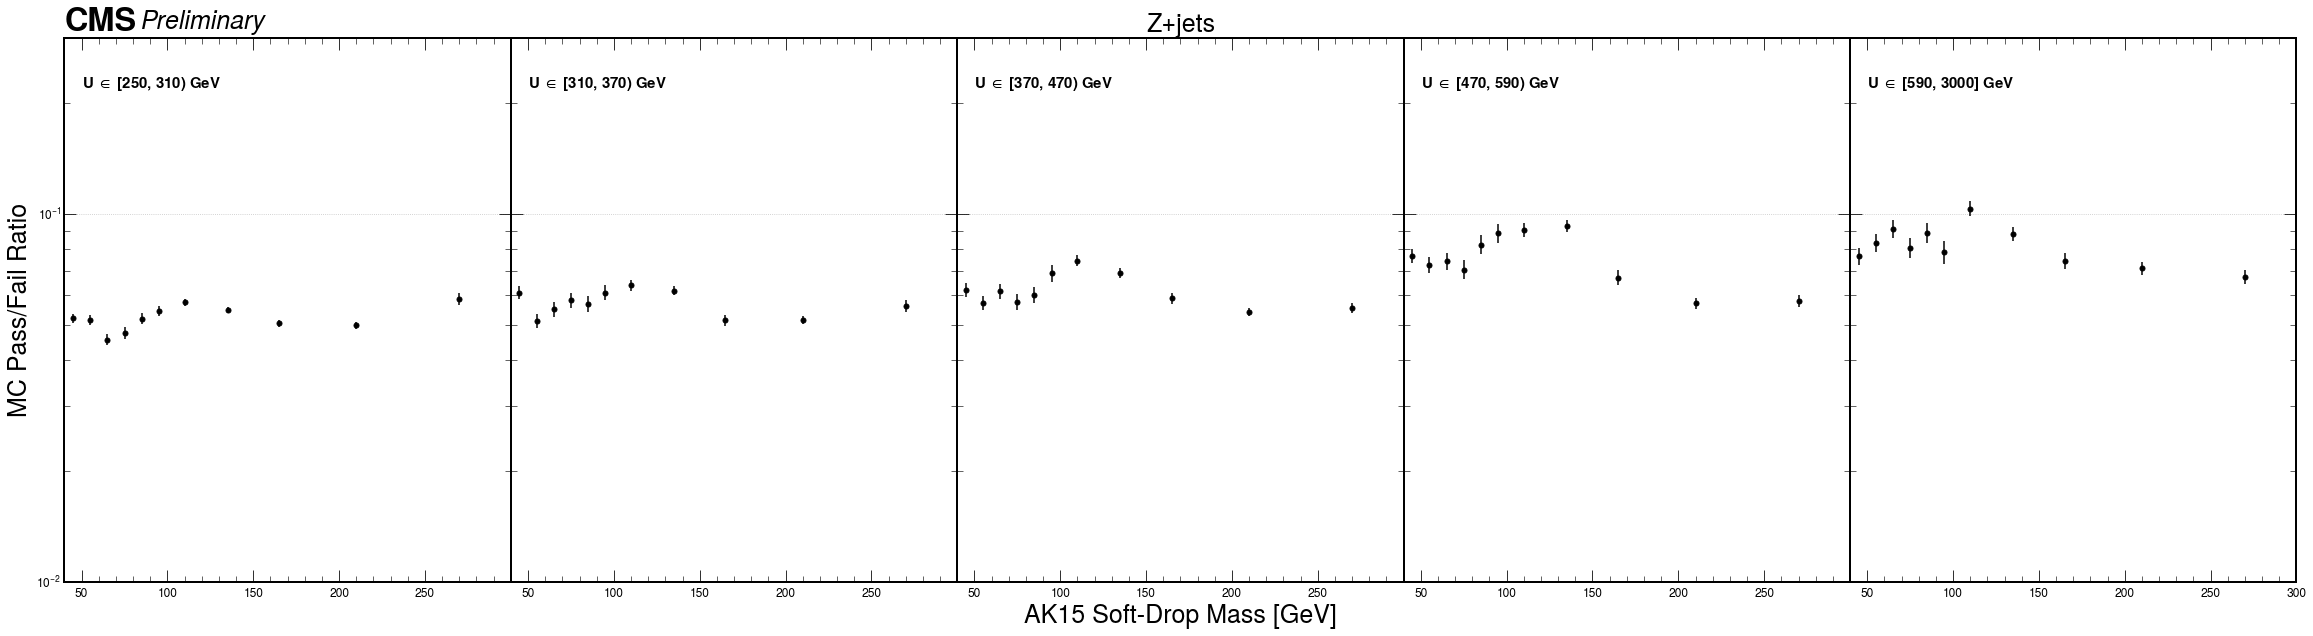

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


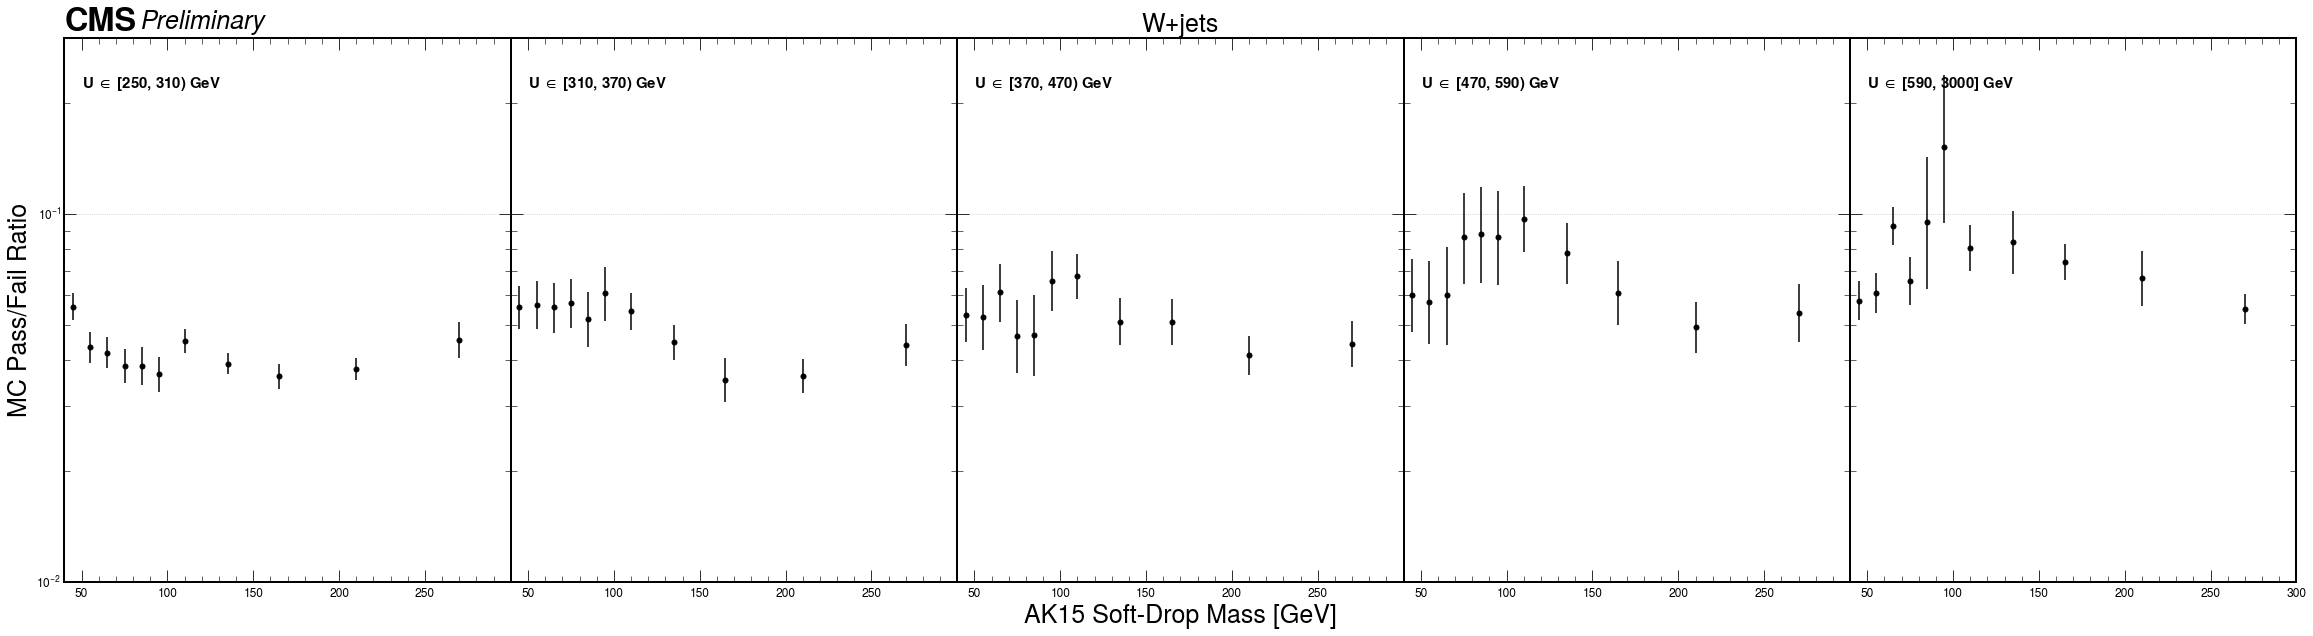

In [5]:
###
# Plot the pass/fail ratio for Z/W+jets as a function of the jet mass in each recoil bin
###

recoilDict = {
    '0':'[250, 310) GeV',
    '1':'[310, 370) GeV',
    '2':'[370, 470) GeV',
    '3':'[470, 590) GeV',
    '4':'[590, 3000] GeV'
}

def plot_1Dratio(vj):
    
    def fill(ax,recoil):
        vjets_hists = {}
        pass_hists  = {}
        fail_hists  = {}

        vjets_hists['template']=bkg_hists['template']

        process = hist.Cat("process", "Process", sorting='placement')
        cats = ("process",)
        sig_map = OrderedDict()
        vjets_map = OrderedDict()
        vjets_map["W+jets"] = ("W+*",)
        vjets_map["Z+jets"] = ("Z+*",)
        vjets_hists['template']=vjets_hists['template'].group(cats, process, vjets_map)
        recoil_binning_dict = {
                '0': [250, 310], 
                '1': [310, 370], 
                '2': [370, 470], 
                '3': [470, 590], 
                '4': [590, 3000]
        }
        vjets_hists['template']=vjets_hists['template'].rebin('recoil',hist.Bin('recoil','Recoil',recoil_binning_dict[str(recoil)]))

        pass_hists['template']=vjets_hists['template'].rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',pass_binning))
        fail_hists['template']=vjets_hists['template'].rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',fail_binning))

        #http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
        from cycler import cycler

        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
        ax.set_prop_cycle(cycler(color=colors))
        plot.plotratio(pass_hists['template'].integrate('region','sr').integrate('systematic','nominal').integrate('process',vj).sum('recoil','ZHbbvsQCD'),
                    fail_hists['template'].integrate('region','sr').integrate('systematic','nominal').integrate('process',vj).sum('recoil','ZHbbvsQCD'),
                    ax=ax,
                    #overflow='over',
                    error_opts=data_err_opts,
                    denom_fill_opts={},
                    guide_opts={},
                    unc='num'
                    )
        ax.set_ylim(0.01,0.3)
        ax.grid(axis='y')
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        ax.text(s='U $\in$ '+recoilDict[str(recoil)], y=2.2e-1, x=50, fontsize=15, weight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([50,100,150,200,250])
    
    fig, axs = plt.subplots(1, 5, figsize=(40,10), sharey='row',
                            gridspec_kw=dict(wspace=0.))
    ax=axs[0]
    fill(ax,0)
    ax.set_ylabel('MC Pass/Fail Ratio', fontsize=25)
    hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
    ax=axs[1]
    fill(ax,1)
    ax=axs[2]
    fill(ax,2)
    ax.set_title(vj, loc='center', fontsize=25)
    ax.set_xlabel('AK15 Soft-Drop Mass [GeV]', fontsize=25)
    ax=axs[3]
    fill(ax,3)
    ax=axs[4]
    fill(ax,4)
    ax.set_xticks([50,100,150,200,250,300])
    
    #coffee = plt.text(0., 1., u"☕ "+'Pass/Fail Ratio, Recoil '+str(recoil), fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    os.system('mkdir -p ../plots/darkhiggs/systematics/'+year+'/')
    plot_path = os.path.abspath('../plots/darkhiggs/systematics/'+year+'/')
    plot_name = '1Dratio_'+vj+'.png'
    fig.savefig(os.path.join(plot_path, plot_name))

plot_1Dratio('Z+jets')
plot_1Dratio('W+jets')

In [ ]:
###
# Plot the pass/fail ratio for Z/W+jets as a function of the jet mass in each recoil bin
###

vjets_hists = {}
pass_hists  = {}
fail_hists  = {}

vjets_hists['template']=bkg_hists['template']

process = hist.Cat("process", "Process", sorting='placement')
cats = ("process",)
sig_map = OrderedDict()
vjets_map = OrderedDict()
#vjets_map["DY+jets"] = ("DY+*",)
vjets_map["W+jets"] = ("W+*",)
vjets_map["Z+jets"] = ("Z+*",)
#vjets_map["G+jets"] = ("G+*",)
for key in vjets_hists.keys():
    vjets_hists[key]=vjets_hists[key].group(cats, process, vjets_map)
    
pass_hists['template']=vjets_hists['template'].rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',pass_binning))
fail_hists['template']=vjets_hists['template'].rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',fail_binning))
pass_zjets=pass_hists['template'].integrate('process','Z+jets').integrate('region','sr').integrate('systematic','nominal').sum('ZHbbvsQCD')
fail_zjets=fail_hists['template'].integrate('process','Z+jets').integrate('region','sr').integrate('systematic','nominal').sum('ZHbbvsQCD')
pass_wjets=pass_hists['template'].integrate('process','W+jets').integrate('region','sr').integrate('systematic','nominal').sum('ZHbbvsQCD')
fail_wjets=fail_hists['template'].integrate('process','W+jets').integrate('region','sr').integrate('systematic','nominal').sum('ZHbbvsQCD')

msdbins=pass_zjets.axis('fjmass').edges()
recoilbins=pass_zjets.axis('recoil').edges()
X, Y = np.meshgrid(recoilbins[:-1] + 0.3 * np.diff(recoilbins), msdbins[:-1] + 0.5 * np.diff(msdbins), indexing='ij')

def plot2D(X, Y, Z, Process):
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))
    #surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(X, Y, Z, rstride=20, cstride=20)
    ax.set_title(Process)
    ax.set_xlabel('Mass',fontsize = 14)
    ax.set_ylabel('Recoil',fontsize = 14)
    ax.set_zlabel('Pass/Fail Ratio',fontsize = 14)
    plt.show()
    os.system('mkdir -p ../plots/darkhiggs/systematics/'+year+'/')
    plot_path = os.path.abspath('../plots/darkhiggs/systematics/'+year+'/')
    plot_name = '2Dratio_sr_'+Process+'.png'
    fig.savefig(os.path.join(plot_path, plot_name))

Z=np.array(pass_zjets.values()[()])/np.array(fail_zjets.values()[()])
plot2D(X, Y, Z, 'Z+jets')
Z=np.array(pass_wjets.values()[()])/np.array(fail_wjets.values()[()])
plot2D(X, Y, Z, 'W+jets')
# Customize the z axis.
#ax.set_zlim(0.04, 0.11)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

#plt.show()

In [ ]:
###
# Postfit plots
###

import uproot as up
from cycler import cycler
import mplhep as hep
import matplotlib.pyplot as plt

#hep.style.use("CMS")

processNames = {
    'qcdMC': 'QCD',
    'tt': r'$t\bar{t}$',
    'ttMC': r'$t\bar{t}$',
    'stMC': 'Single t',
    'vvMC': 'Diboson',
    'hbbMC': r'$H\rightarrow b\bar{b}$',
    'dyjetsMC': 'DY+jets',
    'wjets': 'W+jets',
    'wjetsMC': 'W+jets',
    'zjets': 'Z+jets'
    #'Mhs_50': 'Signal'
}

#colors = ['#99ffff', '#ccffcc', '#ffcc66', '#ff9999', '#ffff99', '#ffccff', '#ccccff']
#bkg_map["Hbb"] = ("Hbb*",)
#bkg_map["QCD"] = ("QCD*",)
#bkg_map["VV"] = (["WW", "WZ", "ZZ"],)
#bkg_map["ST"] = (["ST"],)
#bkg_map["TT"] = (["TT"],)
#bkg_map["W+jets"] = (["W+HF","W+LF"],)
#bkg_map["Z+jets"] = (["DY+HF","Z+HF","DY+LF","Z+LF"],)
colorDict = {
    'DY+jets': '#99ffff',
    r'$H\rightarrow b\bar{b}$': '#ccccff',
    'QCD': '#ffccff',
    'Diboson': '#ffff99',
    'Single t': '#ff9999',
    r'$t\bar{t}$': '#ffcc66',
    'W+jets': '#ccffcc',
    'Z+jets':'#99ffff'
}
mc_labels40to120 = ['DY+jets','Z+jets', r'$H\rightarrow b\bar{b}$', 'QCD', 'Diboson', 'Single t', r'$t\bar{t}$', 'W+jets']
mc_labels120to300 = ['DY+jets', 'Z+jets', r'$H\rightarrow b\bar{b}$', 'QCD', 'Diboson', 'Single t', r'$t\bar{t}$', 'W+jets']
    
def plot_postfit(region, year, category, recoil, processes40to120, processes120to300):
    print(region, year, category, recoil)
    identifier40to120 = region+year+category+'mass40to120recoil'+recoil
    identifier120to300 = region+year+category+'mass120to300recoil'+recoil
    
    f = up.open("../hists/darkhiggs.postfit")

    prefit_dir40to120 = f[identifier40to120+'_prefit']
    postfit_dir40to120 = f[identifier40to120+'_postfit']

    prefit_dir120to300 = f[identifier120to300+'_prefit']
    postfit_dir120to300 = f[identifier120to300+'_postfit']

    totbkg40to120 = prefit_dir40to120["TotalBkg"].values.tolist()
    edges40to120 = prefit_dir40to120["TotalBkg"].edges.tolist()
    #print(prefit40to120, edges40to120)

    totbkg120to300 = prefit_dir120to300["TotalBkg"].values.tolist()
    edges120to300 = prefit_dir120to300["TotalBkg"].edges.tolist()
    edges120to300 = np.delete(edges120to300, 0) ## remove duplicate number
    #print(prefit120to300, edges120to300)

    totbkg_bin = np.concatenate((totbkg40to120, totbkg120to300), axis=None)
    total_edges = np.concatenate((edges40to120, edges120to300), axis=None)

    totbkg = totbkg_bin.tolist()
    edges = total_edges.tolist()

    fig, (ax, rax) = plt.subplots(2, 1, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.4}
    ax.set_ylabel('Events/GeV', fontsize=15)
    ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
    args = {'linestyle':'--', 'linewidth': 5}
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 5e+5)
    hep.cms.label(ax=ax, loc=0, lumi=lumi, year=year, fontsize=15)

    ### Move to draw postfit
    sum_prefit = np.zeros(len(edges)-1)
    sum_postfit = np.zeros(len(edges)-1)
    process_bin = []
    mc_list = []

    keys40to120 = []
    for i in postfit_dir40to120.keys():
        keys40to120.append(str(i).replace('b\'','').replace(';1\'',''))
    keys120to300 = []
    for i in postfit_dir120to300.keys():
        keys120to300.append(str(i).replace('b\'','').replace(';1\'',''))

    for (i, j) in zip(processes40to120, processes120to300):
        print('Which process', i, j)
        if not i in keys40to120:
            print('Not found, skip this process')
            print('Remove its label too \n')
            continue
        else:
            prefit40to120 = prefit_dir40to120[i].values
            postfit40to120 = postfit_dir40to120[i].values

        if not j in keys120to300:
            print('Not found, skip this process')
            print('Remove its label too \n')
            continue
        else:
            prefit120to300 = prefit_dir120to300[j].values
            postfit120to300 = postfit_dir120to300[j].values

        prefit_bin = np.concatenate((prefit40to120, prefit120to300), axis=None)
        postfit_bin = np.concatenate((postfit40to120, postfit120to300), axis=None)
        sum_prefit += prefit_bin
        sum_postfit += postfit_bin
        process_bin.append(postfit_bin.tolist())
        mc_list.append(processNames[j])

    prefit = sum_prefit.tolist()
    #print('TotalBkg:',totbkg)
    #print('Prefit:',prefit)
    postfit = sum_postfit.tolist()
    colors=[]
    for x in mc_list:
        #print(x,colorDict[x])
        colors.append(colorDict[x])
    colors.reverse()
    #print(mc_list)
    #print(colors)
    ax.set_prop_cycle(cycler(color=colors))

    ### Try to draw stack plots
    hep.histplot(process_bin, edges, ax=ax, stack=True, histtype='fill', edgecolor = 'k', linewidth=1, label=mc_list)

    ### Draw Stat. unc.
    #ax.stairs(
    #    values=sum_postfit + np.sqrt(sum_postfit),
    #    baseline=sum_postfit - np.sqrt(sum_postfit),
    #    edges=edges, **errps, label='Stat. unc.')

    hep.histplot(postfit, edges, ax=ax, label=["SM total (post-fit)"], color='b', linewidth=3)
    hep.histplot(prefit, edges, ax=ax, label=["SM total (pre-fit)"], color='r', linestyle='dashed', linewidth=2)

    ### Call data ###
    data40to120 = postfit_dir40to120["data_obs"].values
    data120to300 = postfit_dir120to300["data_obs"].values
    data = np.concatenate((data40to120, data120to300), axis=None)
    #print('Data:',data)
    hep.histplot(data, edges, ax=ax, histtype='errorbar', label="Data", color='k')

    from hist.intervals import ratio_uncertainty
    yerr = ratio_uncertainty(data, sum_postfit, 'poisson')
    #rax.stairs(1+yerr[1], edges=edges, baseline=1-yerr[0], **errps)

    hep.histplot(data/prefit, edges, yerr=np.sqrt(data)/prefit, ax=rax, histtype='errorbar', color='r', capsize=4, label="Prefit")
    hep.histplot(data/sum_postfit, edges, yerr=np.sqrt(data)/sum_postfit, ax=rax, histtype='errorbar', color='b', capsize=4, label="Postfit")

    rax.axhline(1, ls='--', color='k')
    rax.set_ylim(0.5, 1.5)
    rax.set_xlabel('AK15 Mass [GeV]', fontsize=15)
    rax.set_ylabel('Obs/Exp', fontsize=15)#, loc='center')
    rax.legend(loc='upper right', fontsize=12, ncol=2)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=12, ncol=2)
    os.system('mkdir -p ../plots/darkhiggs/postfit/'+year+'/')
    plot_path = os.path.abspath('../plots/darkhiggs/postfit/'+year+'/')
    plot_name = region+'_'+category+'_recoil'+recoil+'.png'
    #fig.savefig(os.path.join(plot_path, plot_name))


#sr 
for i in range(4):
    #fail
    processes40to120 = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'wjets', 'zjets']
    processes120to300 = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'wjets', 'zjets']
    plot_postfit('sr', year, 'fail', str(i), processes40to120, processes120to300)

    #sr pass
    processes40to120 = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'wjets', 'zjets']
    processes120to300 = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'tt', 'wjets', 'zjets']
    plot_postfit('sr', year, 'pass', str(i), processes40to120, processes120to300)
    
#fail
processes40to120 = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'wjets', 'zjets']
processes120to300 = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'wjets', 'zjets']
plot_postfit('sr', year, 'fail', '4', processes40to120, processes120to300)

#sr pass
processes40to120 = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'wjetsMC', 'zjets']
processes120to300 = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'wjetsMC', 'zjets']
plot_postfit('sr', year, 'pass', '4', processes40to120, processes120to300)



In [ ]:
import pandas as pd

def DF(value, year='', cl=''):
    limit_Mz = []
    limit_Mdm = []
    limit_lm = []
    limit_mhs = []

    path='../logs/condor/fit/out/darkhiggs'+year+'_*mhs*_'+cl+'expAsymptoticLimits'
    logs=path.split('/')[-1]
    folder=path.replace(logs,'')

    for log in os.listdir(folder):
      #if logs.replace('*','') not in log: continue
      if not all(piece in log for piece in logs.split('*')): continue
      for line in open(folder+'/'+log,'r').readlines():
        if 'Observed Limit:' not in line: continue
        if value not in line: continue
        Mz, mhs, Mdm = line.strip().split('<')[0].split(':')[1].replace('_r','').split('_')
        Mz = Mz.replace('Mz','')
        mhs = mhs.replace('mhs','')
        Mdm = Mdm.replace('Mdm','')
        limit = line.strip().split('<')[1]

        if float(Mdm)!=100:
            print(Mdm)
            limit_lm.append(float(limit))
            limit_Mz.append(float(Mz))
            limit_Mdm.append(float(Mdm))
            limit_mhs.append(mhs)
        
    data = pd.DataFrame(
        {
            #"obs" : 0.02*np.array(limit_lm)[:,1,5]/xsec,
            "exp" : np.array(limit_lm),
            "Mz"  : np.array(limit_Mz),
            "Mdm"  : np.array(limit_Mdm),
            "mhs" : np.array(limit_mhs)
        }
    )
    data = data.sort_values(by=['Mdm'])
    data = data.sort_values(by=['Mz'])
    return pd.DataFrame.from_dict(data)
        
df50 = DF('mhs50')
print(df50)
df70 = DF('mhs70')
df90 = DF('mhs90')
df110 = DF('mhs110')
df130 = DF('mhs130')
#df150 = DF('mhs150')
df50cl90 = DF('mhs50','','cl90')
df70cl90 = DF('mhs70','','cl90')
df90cl90 = DF('mhs90','','cl90')
df110cl90 = DF('mhs110','','cl90')
df130cl90 = DF('mhs130','','cl90')
#df150cl90 = DF('mhs150','','cl90')

In [ ]:
import sys
sys.path.append('../')
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import pyplot as plt
from libs.limitlib import fill_dummy_values, interpolate_rbf, dump_contour_to_txt


pjoin = os.path.join

import mplhep as hep

plt.style.use(hep.style.CMS)

cmap = mcolors.LinearSegmentedColormap.from_list("n", list(reversed([
    # '#fff5f0',
    '#fee0d2',
    '#ffffff',
    '#fcbba1',
    '#fc9272',
    '#fb6a4a',
    '#ef3b2c',
    '#cb181d',
    '#a50f15',
    '#67000d',
    # '#000000',
        ])))

def plot2d(df):
    plt.clf()
    fig = plt.figure(figsize=(14,10))
    ax = plt.gca()
    plt.plot()

    #excluded = df['exp'] < 1

    x = df['Mz']
    y = df['Mdm']
    exp = df['exp']
    #p1s = df['p1s']
    #m1s = df['m1s']
    #p2s = df['p2s']
    #m2s = df['m2s']
    
    #mask = ~((x==1600) & (y==650))
    #x = x[mask]
    #y = y[mask]
    #exp = exp[mask]
    #p1s = p1s[mask]
    #m1s = m1s[mask]
    #p2s = p2s[mask]
    #m2s = m2s[mask]

    contours_filled = np.log10(np.logspace(-1,1,7))
    contours_line = [0]
    
    def get_x_y_z(x,y,z):
        ix, iy, iz = interpolate_rbf(x,y,z,maxval=4000)
        iz [iy>ix] = 1e9 #* np.exp(-(iy/ix))
        if True:
            iz = np.log10(iz)
            iz[iz<min(contours_filled)] = min(contours_filled)
        return ix, iy, iz

    ix, iy, iz = get_x_y_z(x, y, exp)
    CF = plt.contourf(ix, iy, iz, levels=contours_filled, cmap=cmap)
    cb = plt.colorbar()
    for c in CF.collections:
        c.set_edgecolor("face")
        
    args = dict(colors='black',zorder=2,levels=contours_line)
    cs_exp = plt.contour(
                       ix, iy, iz,
                       linestyles=[(0, (5,1))],
                       linewidths=3,
                       **args)
    cs_exp.collections[0].set_label('Median expected')
    
    #cs_p1s=plt.contour(
    #            *get_x_y_z(x,y,p1s),
    #            linestyles=[(0, (3,3))],
    #            linewidths=2,
    #            **args)
    #cs_p1s.collections[0].set_label(r'68% expected')
    #cs_m1s = plt.contour(
    #            *get_x_y_z(x,y,m1s),
    #            linestyles=[(0, (3,3))],
    #            linewidths=2,
    #            **args)
    
    #cs_p2s=plt.contour(
    #            *get_x_y_z(x,y,p2s),
    #            linestyles=[(0, (1,5))],
    #            linewidths=2,
    #            **args)
    #cs_p2s.collections[0].set_label(r'95% expected')
    #cs_m1s = plt.contour(
    #            *get_x_y_z(x,y,m2s),
    #            linestyles=[(0, (1,5))],
    #            linewidths=2,
    #            **args)
    cb.set_label("95% CL observed upper limit on $\log_{10}(\mu)$")
    plt.clim([1e-1,1e1])
    
    ax.set_xlabel("$m_{Z'}$ (GeV)")
    ax.set_ylabel("$m_{DM}$ (GeV)")
    ax = plt.gca()
    ax.set_ylim(int(df['mhs'][0]),1000)
    ax.set_xlim(int(df['mhs'][0]),3500)

    plt.legend(loc='upper left')

    plt.text(3400,950,'\n'.join([f'Dark Higgs mass = '+df['mhs'][0]+' GeV','Majorana DM',]), ha='right',va='top')

    #plt.text(2800,1100,"CMS", fontweight='bold', ha='right',va='bottom',fontsize=30)
    hep.cms.label(data=True, year='2016-2018', lumi=137)#, loc=1)#, label="Preliminary")
    plot_path = os.path.abspath('../plots/darkhiggs/results/') 
    plot_name = 'mhs'+df['mhs'][0]+'_2D.png'
    fig.savefig(os.path.join(plot_path, plot_name))
    
    #hep.cms.label(data=True, year='2016-2018', lumi=137, label="Preliminary")
    #for ext in 'pdf','png':
    #    fig.savefig(pjoin(outdir, f"tchan_2d_preliminary.{ext}"))

    #plt.plot(x,y,'+b')
    #for ix, iy, iz in zip(x,y,exp):
    #    plt.text(ix, iy, f"{iz:.7f}",color='b',fontsize=10)

    #for ext in 'pdf','png':
    #    fig.savefig(pjoin(outdir, f"tchan_2d_points.{ext}"))

In [ ]:
plot2d(df50)

In [ ]:
plot2d(df70)

In [ ]:
plot2d(df90)

In [ ]:
plot2d(df110)

In [ ]:
plot2d(df130)

In [ ]:
from matplotlib import pyplot as plt
from libs.limitlib import fill_dummy_values, interpolate_rbf, dump_contour_to_txt

def to_array(df):

    #excluded = df['exp'] < 1

    x = df['Mz']
    y = df['Mdm']
    exp = df['exp']
    #p1s = df['p1s']
    #m1s = df['m1s']
    #p2s = df['p2s']
    #m2s = df['m2s']
    
    #mask = ~((x==1600) & (y==650))
    #x = x[mask]
    #y = y[mask]
    #exp = exp[mask]
    #p1s = p1s[mask]
    #m1s = m1s[mask]
    #p2s = p2s[mask]
    #m2s = m2s[mask]

    contours_filled = np.log10(np.logspace(-1,1,7))
    contours_line = [0]
    
    def get_x_y_z(x,y,z):
        ix, iy, iz = interpolate_rbf(x,y,z,maxval=4000)
        iz [iy>ix] = 1e9 #* np.exp(-(iy/ix))
        if True:
            iz = np.log10(iz)
            iz[iz<min(contours_filled)] = min(contours_filled)
        return ix, iy, iz

    ix, iy, iz = get_x_y_z(x, y, exp)
    
        
    cs_exp = plt.contour(ix, iy, iz,levels=contours_line)
    line_exp = np.array(cs_exp.collections[0].get_paths()[0].vertices)
    return line_exp#[line_exp[:,0]>float(df['mhs'][0])]
    #line_obs = np.array(cs_obs.collections[0].get_paths()[0].vertices)

    #plt.plot(line_exp[:,0], line_exp[:,1], "b-" , label="Expected $90\%$ CL")
    #plt.plot(line_obs[:,0], line_obs[:,1], "k-" , label="Observed $90\%$ CL")

    #np.savetxt('../data/limit-exp-'+df['mhs'][0]+'.csv', line_exp, delimiter=',')
    #np.savetxt('limit-obs-'+df['mhs'][0]+'.csv', line_obs[1660:], delimiter=',')

In [ ]:
darkhiggs50=to_array(df50cl90)
darkhiggs70=to_array(df70cl90)
darkhiggs90=to_array(df90cl90)
darkhiggs110=to_array(df110cl90)
darkhiggs130=to_array(df130cl90)

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SD(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 50 GeV")
values=vector_model.from_array(darkhiggs50[:,0],darkhiggs50[:,1])
values=values[values[:,1]>50.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SD")
plt.legend()

os.system('mkdir -p ../plots/darkhiggs/results/')
plot_path = os.path.abspath('../plots/darkhiggs/results/')
plot_name = 'mhs50_SD.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SI(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 50 GeV")
values=vector_model.from_array(darkhiggs50[:,0],darkhiggs50[:,1])
values=values[values[:,1]>50.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SI")
plt.legend()

os.system('mkdir -p ../plots/darkhiggs/results/')
plot_path = os.path.abspath('../plots/darkhiggs/results/')
plot_name = 'mhs50_SI.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SD(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 70 GeV")
values=vector_model.from_array(darkhiggs70[:,0],darkhiggs70[:,1])
values=values[values[:,1]>70.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SD")
plt.legend()

os.system('mkdir -p ../plots/darkhiggs/results/')
plot_path = os.path.abspath('../plots/darkhiggs/results/')
plot_name = 'mhs70_SD.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SI(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 70 GeV")
values=vector_model.from_array(darkhiggs70[:,0],darkhiggs70[:,1])
values=values[values[:,1]>70.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SI")
plt.legend()

os.system('mkdir -p ../plots/darkhiggs/results/')
plot_path = os.path.abspath('../plots/darkhiggs/results/')
plot_name = 'mhs70_SI.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SD(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 90 GeV")
values=vector_model.from_array(darkhiggs90[:,0],darkhiggs90[:,1])
values=values[values[:,1]>90.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SD")
plt.legend()

plot_path = os.path.abspath('../plots/darkhiggs/results/') 
plot_name = 'mhs90_SD.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SI(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 90 GeV")
values=vector_model.from_array(darkhiggs90[:,0],darkhiggs90[:,1])
values=values[values[:,1]>90.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SI")
plt.legend()

plot_path = os.path.abspath('../plots/darkhiggs/results/')
plot_name = 'mhs90_SI.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SD(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 110 GeV")
values=vector_model.from_array(darkhiggs110[:,0],darkhiggs110[:,1])
values=values[values[:,1]>110.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SD")
plt.legend()

plot_path = os.path.abspath('../plots/darkhiggs/results/') 
plot_name = 'mhs110_SD.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SI(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 110 GeV")
values=vector_model.from_array(darkhiggs110[:,0],darkhiggs110[:,1])
values=values[values[:,1]>110.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SI")
plt.legend()

plot_path = os.path.abspath('../plots/darkhiggs/results/')
plot_name = 'mhs110_SI.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SD(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 130 GeV")
values=vector_model.from_array(darkhiggs130[:,0],darkhiggs130[:,1])
values=values[values[:,1]>130.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SD")
plt.legend()

plot_path = os.path.abspath('../plots/darkhiggs/results/') 
plot_name = 'mhs130_SD.png'
fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
import lhctodd
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
vector_model = lhctodd.SI(g_chi=1.0, g_quark=0.25, label="CMS Dark Higgs 130 GeV")
values=vector_model.from_array(darkhiggs130[:,0],darkhiggs130[:,1])
values=values[values[:,1]>130.]
plt.plot(values[:,1], values[:,0],label= vector_model.label)
lhctodd.plot_all(limit_type="SI")
plt.legend()

plot_path = os.path.abspath('../plots/darkhiggs/results/')
plot_name = 'mhs130_SI.png'
fig.savefig(os.path.join(plot_path, plot_name))